In [1]:
import pandas as pd
import collections
import math
import os

import cv2
import matplotlib.pyplot as plt
import cv2
import sys
import numpy as np
import math
import time
from PIL import Image 

from pandas import read_csv  
import configparser

config = configparser.ConfigParser()
config.read('configBath1p.txt')

source_folder = config.get('Configuration', 'source_folder')
time_step = int(config.get('Configuration', 'time_step'))
data_folder = config.get('Configuration', 'data_folder')
ini_date = config.get('Configuration', 'ini_date')
end_date = config.get('Configuration', 'end_date')

window_size = int(config.get('Configuration', 'window_size'))

scenes=config.get('Configuration', 'scenes')
scenes = [(item.strip()) for item in scenes.split(',')]

print(scenes)

users=config.get('Configuration', 'users')
users = [(item.strip()) for item in users.split(',')]

anchors=config.get('Configuration', 'anchors')
anchors = [(item.strip()) for item in anchors.split(',')]

room=config.get('Configuration', 'room')

w = int(config.get(room, 'w'))
h = int(config.get(room, 'h'))

user_color={}
for user in users:
    user_color[user]=config.get('Colors', user)
print(user_color)


['Scene1', 'Scene2', 'Scene3', 'Scene4']
{'ed9c': 'red'}


In [2]:
import numpy as np
from pandas import read_csv    
import pandas as pd
import time

from datetime import datetime

off_zone=60*60*2

def day_time(ti):
    return int((int)((ti+off_zone)/(60*60*24)))


def time2str(tt):
    return datetime.fromtimestamp(tt).strftime("%Y-%m-%d %H:%M:%S")


t0 = (int)(datetime.strptime(ini_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (ini_date,"Init date is", t0, "day:",day_time(t0), time2str(t0))

tN = (int)(datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (end_date,"End date is", tN, "day:",day_time(tN), time2str(tN))


def day_time0(ti):
    return day_time(ti)-day_time(t0)+1

def relT(ti):
    return (int)((ti-t0)/time_step)

days=list(range(day_time(t0),day_time(tN)+1))
print(days)

i0=0
ts=list(range(t0,tN,1))
print(i0,ts)
print(len(ts))

2024-03-16 19:23:36 Init date is 1710613416 day: 19798 2024-03-16 19:23:36
2024-03-16 19:45:28 End date is 1710614728 day: 19798 2024-03-16 19:45:28
[19798]
0 [1710613416, 1710613417, 1710613418, 1710613419, 1710613420, 1710613421, 1710613422, 1710613423, 1710613424, 1710613425, 1710613426, 1710613427, 1710613428, 1710613429, 1710613430, 1710613431, 1710613432, 1710613433, 1710613434, 1710613435, 1710613436, 1710613437, 1710613438, 1710613439, 1710613440, 1710613441, 1710613442, 1710613443, 1710613444, 1710613445, 1710613446, 1710613447, 1710613448, 1710613449, 1710613450, 1710613451, 1710613452, 1710613453, 1710613454, 1710613455, 1710613456, 1710613457, 1710613458, 1710613459, 1710613460, 1710613461, 1710613462, 1710613463, 1710613464, 1710613465, 1710613466, 1710613467, 1710613468, 1710613469, 1710613470, 1710613471, 1710613472, 1710613473, 1710613474, 1710613475, 1710613476, 1710613477, 1710613478, 1710613479, 1710613480, 1710613481, 1710613482, 1710613483, 1710613484, 1710613485, 

In [3]:
scene_user = {}
lista_timestamps=[]
for d in days:
    for user in users:
        scene_user[user] = {}
        for s in scenes:
            print(d,source_folder+"/"+s+"/location_gt_"+user+"/"+str(d)+".location.tsv")
            try:
                series=read_csv(source_folder+"/"+s+"/location_gt_"+user+"/"+str(d)+".location.tsv", sep="\t",parse_dates=True, header=None, names=["time","date","time2","x","y"])
                print(d,series.size,(series["time"].iloc[0],series["time"].iloc[-1]))
                scene_user[user][s] = (series["time"].iloc[0],series["time"].iloc[-1])
                #print("test")
                print(scene_user[user][s])
                #if user=='ed9c':
                lista_timestamps.extend(list(range(scene_user[user][s][0],scene_user[user][s][1],1)))
                #print(lista_timestamps)
                #print("test2")
            except Exception as e:
                print("Not data",e)
                continue
def getScene(t0):
    for user, user_scene in scene_user.items():
        for scene, times in user_scene.items():
            #print(t0,times[0],times[1])
            if(t0>times[0]-window_size/2 and t0<times[1]+window_size/2):
                return scene
    return None

19798 ./data/bathroom/1-person-labelled/Scene1/location_gt_ed9c/19798.location.tsv
19798 715 (1710613416, 1710613589)
(1710613416, 1710613589)
19798 ./data/bathroom/1-person-labelled/Scene2/location_gt_ed9c/19798.location.tsv
19798 805 (1710613851, 1710614025)
(1710613851, 1710614025)
19798 ./data/bathroom/1-person-labelled/Scene3/location_gt_ed9c/19798.location.tsv
19798 870 (1710614200, 1710614393)
(1710614200, 1710614393)
19798 ./data/bathroom/1-person-labelled/Scene4/location_gt_ed9c/19798.location.tsv
19798 970 (1710614539, 1710614728)
(1710614539, 1710614728)


In [4]:
def getFPImg(tt):
    img_path = os.path.join(data_folder+"B", "DAY_" + str(day), "FP." + str(tt) + ".png")
    #print(img_path)
    img = np.array(Image.open(img_path))/255.0
    #print(img)
    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)
    
    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad
    
    #print(top_pad,bottom_pad,left_pad,right_pad)
    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
    
    #print(img_padded)
    # Guardar la imagen sobrescrita
    #Image.fromarray((img_padded * 255).astype(np.uint8)).save(img_path)
    
    return img_padded

def getFPImg0(tt):
    img_path = os.path.join(data_folder, room, "DAY_" + str(day), "FP." + str(tt) + ".png")
    #print(img_path)
    img = np.array(Image.open(img_path))/255.0
    #print(img)
    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)
    
    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad
    
    #print(top_pad,bottom_pad,left_pad,right_pad)
    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
    
    #print(img_padded)
    # Guardar la imagen sobrescrita
    Image.fromarray((img_padded * 255).astype(np.uint8)).save(img_path)
    
    return img_padded

def getGTImg(tt, user):
    img_path = os.path.join(data_folder, room, "DAY_" + str(day), "GT." + user + "." + str(tt) + ".png")
    img = np.array(Image.open(img_path)) / 255.0

    # Calcular el relleno necesario
    h, w = img.shape
    pad_height = max(0, 8 - h)
    pad_width = max(0, 8 - w)

    # Calcular el relleno en la parte superior, inferior, izquierda y derecha
    top_pad = (pad_height + 1) // 2
    bottom_pad = pad_height - top_pad
    left_pad = (pad_width + 1) // 2
    right_pad = pad_width - left_pad

    # Agregar el relleno
    img_padded = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

    # Procesamiento adicional: propagación de valores
    h_padded, w_padded = img_padded.shape
    img_propagated = img_padded.copy()  # Crear una copia para no modificar la original durante el proceso

    for x in range(h_padded):
        for y in range(w_padded):
            if img_padded[x, y] > 0:
                max_val = img_padded[x, y] / 2.0  # Calcular la mitad del valor actual
                neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),(x - 1, y-1), (x + 1, y+1), (x+1, y - 1), (x-1, y + 1)]
                #neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < h_padded and 0 <= ny < w_padded:
                        img_propagated[nx, ny] = max(img_propagated[nx, ny], max_val)

    # Guardar la imagen sobrescrita
    #Image.fromarray((img_propagated * 255).astype(np.uint8)).save(img_path)

    return img_propagated

#test=getFPImg(1710618646)

#test=getFPImg(1710618646)

In [5]:
ts=lista_timestamps
#ts=list(set(ts))

ts=list(dict.fromkeys(ts))
ts.sort()
#ts=list(set(ts))
ts=ts[:-5]
print(enumerate(ts))
print(ts)
print(len(ts))
XY0={}
rssi0={}
Y0={}

T0_user={}
T0=[]
T1=[]
for day in days:
    anchors_data={}
    for user in users:
        XY0[user]=[]
        rssi0[user]=[]
        Y0[user]=[]
        T0_user[user]=[]


        anchors_data[user]={}
        for anchor in anchors:
            print(data_folder+"/"+room+"/DAY_"+str(day)+"/"+user+"."+anchor+".tsv")
            print(user,anchor)
            series=read_csv(data_folder+"/"+room+"/DAY_"+str(day)+"/"+user+"."+anchor+".tsv", sep="\t",parse_dates=True, header=None, names=["time","d"])
            series=series.values
            anchors_data[user][anchor]=series
            

    for it,tt in enumerate(ts):
        print(it,tt)
        imgX=getFPImg(tt)
        print("imgX",imgX.shape)

        for user in users:
            
            imgY=getGTImg(tt,user)
            #if imgY is None:
            #    continue
            print("user",user,"imgY",imgY.shape)

            dist=[]
            for ixa,anchor in enumerate(anchors):
                #if(len(ts))
                d=anchors_data[user][anchor][it][1]
                #print(len(anchors_data[user][anchor]))
                if(d>0):
                    d=d/10.0
                if(d>1):
                    d=1
                print("\t anchor:",anchor, anchors_data[user][anchor][it], "tt:",tt)
                dist.append(d)

            dist=np.array(dist)
            print("dist:",dist)

            rssi0[user].append(dist.reshape(len(anchors),1))
            XY0[user].append(imgX[:, :, np.newaxis])
            Y0[user].append(imgY[:, :, np.newaxis])
            T0_user[user].append(it)
            T0.append(it)
            T1.append(tt)
print(T0)        
print(T1)        
print(len(T1))
T0=list(dict.fromkeys(T0))
T1=list(dict.fromkeys(T1))
print(T0)        
print(T1)
#print(T0_user)

[1710613416, 1710613417, 1710613418, 1710613419, 1710613420, 1710613421, 1710613422, 1710613423, 1710613424, 1710613425, 1710613426, 1710613427, 1710613428, 1710613429, 1710613430, 1710613431, 1710613432, 1710613433, 1710613434, 1710613435, 1710613436, 1710613437, 1710613438, 1710613439, 1710613440, 1710613441, 1710613442, 1710613443, 1710613444, 1710613445, 1710613446, 1710613447, 1710613448, 1710613449, 1710613450, 1710613451, 1710613452, 1710613453, 1710613454, 1710613455, 1710613456, 1710613457, 1710613458, 1710613459, 1710613460, 1710613461, 1710613462, 1710613463, 1710613464, 1710613465, 1710613466, 1710613467, 1710613468, 1710613469, 1710613470, 1710613471, 1710613472, 1710613473, 1710613474, 1710613475, 1710613476, 1710613477, 1710613478, 1710613479, 1710613480, 1710613481, 1710613482, 1710613483, 1710613484, 1710613485, 1710613486, 1710613487, 1710613488, 1710613489, 1710613490, 1710613491, 1710613492, 1710613493, 1710613494, 1710613495, 1710613496, 1710613497, 1710613498, 171

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061392e+09 -1.00000000e+00] tt: 1710613928
dist: [-1.]
251 1710613929
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061393e+09 1.85000000e+00] tt: 1710613929
dist: [0.185]
252 1710613930
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061393e+09 1.85000000e+00] tt: 1710613930
dist: [0.185]
253 1710613931
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061393e+09 -1.00000000e+00] tt: 1710613931
dist: [-1.]
254 1710613932
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061393e+09 -1.00000000e+00] tt: 1710613932
dist: [-1.]
255 1710613933
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061393e+09 1.56900000e+00] tt: 1710613933
dist: [0.1569]
256 1710613934
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061393e+09 1.56900000e+00] tt: 1710613934
dist: [0.1569]
257 1710613935
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061393e+09 -1.00000000e+00] tt: 1710613935
dist: [-1.]
258 171061393

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.710614e+09 -1.000000e+00] tt: 1710614002
dist: [-1.]
325 1710614003
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.710614e+09 3.142000e+00] tt: 1710614003
dist: [0.3142]
326 1710614004
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.710614e+09 3.142000e+00] tt: 1710614004
dist: [0.3142]
327 1710614005
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.710614e+09 -1.000000e+00] tt: 1710614005
dist: [-1.]
328 1710614006
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.710614e+09 -1.000000e+00] tt: 1710614006
dist: [-1.]
329 1710614007
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.710614e+09 -1.000000e+00] tt: 1710614007
dist: [-1.]
330 1710614008
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.710614e+09 2.907000e+00] tt: 1710614008
dist: [0.2907]
331 1710614009
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061401e+09 2.90700000e+00] tt: 1710614009
dist: [0.2907]
332 1710614010
imgX (8, 8)
user ed9c im

imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061462e+09 2.51000000e+00] tt: 1710614634
dist: [0.251]
636 1710614635
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [1.71061463e+09 2.51000000e+00] tt: 1710614635
dist: [0.251]
637 1710614636
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614636
dist: [-1.]
638 1710614637
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614637
dist: [-1.]
639 1710614638
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614638
dist: [-1.]
640 1710614639
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614639
dist: [-1.]
641 1710614640
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614640
dist: [-1.]
642 1710614641
imgX (8, 8)
user ed9c imgY (8, 8)
	 anchor: c492 [ 1.71061463e+09 -1.00000000e+00] tt: 1710614641
dist: [-1.]
643 1710614642


In [6]:
for user in users:
    XY0[user]=np.array(XY0[user])
    rssi0[user]=np.array(rssi0[user])
    Y0[user]=np.array(Y0[user])
T0=np.array(T0)
print(T0)
print(len(T0))
#print(XY0.shape)
#frame0=np.median(XY0, axis=(0)).astype(np.uint8)
#for i in range(0,XY0.shape[0]):
#    XY0[i]=XY0[i]-frame0
#print(XY0.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [7]:
minT=np.min(T0)
maxT=np.max(T0)

print(T0)
print(len(T0))
print(minT)
print(maxT)

print(T1)
print(len(T1))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [8]:
XYT=[]
rssiT=[]
YT=[]

TA=int(window_size/2)
TB=int(window_size/2)

T=window_size

S=[]
for user in users:
    print("Usuario ",user)
    for t in range(minT+TA,maxT-TB):

        
        tt=T1[t]
        scene=getScene(tt)
        
        print("Scene",scene,tt,t)
        if not scene:
            continue

        subW=list(range(t-TA,t+TB))
        print("subW:",subW, "t:",t)
        if not (set(subW).intersection(set(T0)) == set(subW)):
            print("Not data for sliding window!",t)
            continue

        #print("rssi0[t-T:t+T]",rssi0[t-T:t+T].flatten())
        if(all(map(lambda x: x == -1, rssi0[user][t-TA:t].flatten()))):
            print("Distance -1 for RSSI in sliding window!",t)
            continue

        if(all(map(lambda x: x == -1, rssi0[user][t:t+TB].flatten()))):
            print("Distance -1 for RSSI in sliding window!",t)
            continue

        if(all(map(lambda x: x == 0, Y0[user][t].flatten()))):
            print("Distance 0 for Y0 in t!",t)
            continue


        if(XY0[user][t-TA:t+TB].shape[0]!=T):
            print("#",XY0[user][t-TA:t+TB].shape)
            continue
        if(rssi0[user][t-TA:t+TB].shape[0]!=T):
            print("@",rssi0[user][t-TA:t+TB].shape)
            continue

        XYT.append(XY0[user][t-TA:t+TB])
        rssiT.append(rssi0[user][t-TA:t+TB])
        YT.append(Y0[user][t])
        S.append(scene)
        #print(S)
#print(S)
XYT=np.array(XYT)
rssiT=np.array(rssiT)
YT=np.array(YT)    
S=np.array(S)    
print(XYT.shape)
print(rssiT.shape)
print(YT.shape)


Usuario  ed9c
Scene Scene1 1710613418 2
subW: [0, 1, 2, 3] t: 2
Scene Scene1 1710613419 3
subW: [1, 2, 3, 4] t: 3
Scene Scene1 1710613420 4
subW: [2, 3, 4, 5] t: 4
Distance -1 for RSSI in sliding window! 4
Scene Scene1 1710613421 5
subW: [3, 4, 5, 6] t: 5
Scene Scene1 1710613422 6
subW: [4, 5, 6, 7] t: 6
Distance -1 for RSSI in sliding window! 6
Scene Scene1 1710613423 7
subW: [5, 6, 7, 8] t: 7
Scene Scene1 1710613424 8
subW: [6, 7, 8, 9] t: 8
Distance -1 for RSSI in sliding window! 8
Scene Scene1 1710613425 9
subW: [7, 8, 9, 10] t: 9
Distance -1 for RSSI in sliding window! 9
Scene Scene1 1710613426 10
subW: [8, 9, 10, 11] t: 10
Distance -1 for RSSI in sliding window! 10
Scene Scene1 1710613427 11
subW: [9, 10, 11, 12] t: 11
Distance -1 for RSSI in sliding window! 11
Scene Scene1 1710613428 12
subW: [10, 11, 12, 13] t: 12
Distance -1 for RSSI in sliding window! 12
Scene Scene1 1710613429 13
subW: [11, 12, 13, 14] t: 13
Distance -1 for RSSI in sliding window! 13
Scene Scene1 1710613430 

In [9]:
import matplotlib.pyplot as plt

L=20

# Create a figure with two subplots (one row, two columns)
fig, axes = plt.subplots(L, 2, figsize=(200, 200))


for k in range(0,L):
    mpAll=XY0[users[0]][k].reshape(w,h)

    axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
    axes[k,0].set_title('All players (last frame)')
    axes[k,0].axis('off')

    mpOne=Y0[users[0]][k].reshape(w,h)

    axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
    axes[k,1].set_title('True (last frame) of player')
    axes[k,1].axis('off')

    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [10]:
from tensorflow import keras

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D,Activation, Dense

from tensorflow import Tensor
from tensorflow.keras.layers import Softmax,Input, Conv1D, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense,Dropout,LSTM,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from keras.losses import mean_squared_error

from keras import backend as K

from sklearn.model_selection import KFold

from tensorflow import keras

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.layers import MaxPooling2D,Activation, Dense

from tensorflow import Tensor
from tensorflow.keras.layers import Multiply,MaxPooling3D, ConvLSTM1D, Lambda, Dot,Reshape,Multiply, Input, Conv1D, Conv2D, ConvLSTM2D,ReLU,UpSampling2D, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense,Dropout,LSTM,TimeDistributed,MaxPooling1D, Concatenate
from tensorflow.keras.models import Model, Sequential

from keras import backend as K
import math

from tensorflow.keras.losses import CategoricalCrossentropy

import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv2DTranspose

In [11]:
#MODELO A

K=len(anchors)
print(K)
print(T)
rssi = Input(shape=(T,K,1))
print(rssi)

encoded_rssi = ConvLSTM1D(filters=16, kernel_size=3, activation='relu', padding='same', return_sequences=True, input_shape=(None, K, 1))(rssi)
encoded_rssi = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(encoded_rssi)
encoded_rssi = ConvLSTM1D(filters=32, kernel_size=3, activation='relu', padding='same', return_sequences=True)(encoded_rssi)
print("encoded_rssi",encoded_rssi.shape)
print("encoded_rssi max pool",encoded_rssi.shape)
encoded_rssi = ConvLSTM1D(filters=64, kernel_size=3, activation='relu', padding='same', return_sequences=True)(encoded_rssi)


print("lstm",encoded_rssi.shape)
#encoded_rssi=Reshape((T,1,1,128))(encoded_rssi)


N=w
M=h

xy = Input(shape=(T,N,M,1))
print(xy)


#LayerNormalization
encoded= ConvLSTM2D(16 , 3,return_sequences=True, padding='same')(xy)
print(encoded.shape)
encoded = MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1), padding='valid')(encoded)
print(encoded.shape)
encoded= ConvLSTM2D(32 , 3,return_sequences=True, strides=(2, 2) , padding='same')(encoded)
print(encoded.shape)
#encoded = MaxPooling3D(pool_size=(2, 1, 1), strides=(1, 1, 1), padding='valid')(encoded)
print(encoded.shape)
encoded= ConvLSTM2D(64 , 3,return_sequences=False, strides=(2, 2), padding='same')(encoded)




rssi_lstm_flattened = Flatten()(encoded_rssi)
xy_lstm_flattened = Flatten()(encoded)

# Fusión de características


print(rssi_lstm_flattened.shape)
print(xy_lstm_flattened.shape)

merged = Concatenate()([rssi_lstm_flattened, xy_lstm_flattened])

print(merged.shape)
merged = Dense(512)(merged)
print(merged.shape)

reshape = Reshape((2, 2, 128))(merged) 


# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)

autoencoder = Model([xy,rssi], conv2dtranspose2)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
#autoencoder.compile(optimizer=Adam(learning_rate=0.001),
#              loss=CategoricalCrossentropy(),
#              metrics=['accuracy'])

print(encoded)
autoencoder.save("model0.h5")
autoencoder.summary()


1
4
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 1, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
encoded_rssi (None, 2, 1, 32)
encoded_rssi max pool (None, 2, 1, 32)
lstm (None, 2, 1, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 8, 8, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
(None, 4, 8, 8, 16)
(None, 2, 8, 8, 16)
(None, 2, 4, 4, 32)
(None, 2, 4, 4, 32)
(None, 128)
(None, 256)
(None, 384)
(None, 512)
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 64), dtype=tf.float32, name=None), name='conv_lstm2d_2/strided_slice_2:0', description="created by layer 'conv_lstm2d_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 1, 1)]            0         []                  

C:\Users\Usuario\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
#MODELO SOLO LSTM

# Rama secuencial
K=len(anchors)

rssi_input = Input(shape=(T, K, 1))
rssi_flattened = TimeDistributed(Flatten())(rssi_input)
rssi_lstm = LSTM(units=256, return_sequences=False)(rssi_flattened)

N=w
M=h

xy_input = Input(shape=(T, N, M, 1))
xy_flattened = TimeDistributed(Flatten())(xy_input)
xy_lstm1 = LSTM(units=256, return_sequences=True)(xy_flattened)  # Mayor capacidad
xy_lstm2 = LSTM(units=256, return_sequences=False)(xy_lstm1)  # Segunda capa LSTM

print(xy_lstm2)

# Aplastando las salidas para que puedan ser concatenadas
rssi_lstm_flattened = Flatten()(rssi_lstm)
xy_lstm_flattened = Flatten()(xy_lstm2)

# Fusión de características

merged = Concatenate()([rssi_lstm_flattened, xy_lstm_flattened])
print(merged.shape)
merged = Dense(512)(merged)
print(merged.shape)

reshape = Reshape((2, 2, 128))(merged) 


# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)

# Modelo
model = Model(inputs=[xy_input, rssi_input], outputs=conv2dtranspose2)

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

model.save("model1.h5")
model.summary()



KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:0', description="created by layer 'lstm_2'")
(None, 512)
(None, 512)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 4, 1, 1)]            0         []                            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 4, 64)                0         ['input_4[0][0]']             
 stributed)                                                                                       
           

In [13]:
#MODELO LIGERO: LSTM+CONV+LSTM

# Rama secuencial
K=len(anchors)
print(K)

rssi = Input(shape=(T,K,1))
print(rssi)
lstm1=TimeDistributed(Flatten())(rssi)

lstm_out = LSTM(units=256)(lstm1)
print("LSTM",lstm_out)

N=w
M=h

print(w,h)

xy = Input(shape=(T,N,M,1))
print(xy)

conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(xy)
conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(conv1)
conv_out = TimeDistributed(Flatten())(conv2)
print("CONV",conv_out)

lstm2= LSTM(units=128,return_sequences=True)(conv_out)
lstm2=LSTM(units=256,return_sequences=False)(lstm2)
lstm2_out=Flatten()(lstm2)
print(lstm_out.shape)
print(lstm2_out.shape)

# Fusión de características

merged = Concatenate()([lstm_out, lstm2_out])

print(merged.shape)
merged = Dense(512)(merged)
print(merged.shape)

reshape = Reshape((2, 2, 128))(merged) 

# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)


# Modelo
model = Model(inputs=[xy, rssi], outputs=conv2dtranspose2)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae']) 

model.save("model2.h5")
model.summary()

1
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 1, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
LSTM KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:0', description="created by layer 'lstm_3'")
8 8
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 8, 8, 1), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
CONV KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4096), dtype=tf.float32, name=None), name='time_distributed_3/Reshape_1:0', description="created by layer 'time_distributed_3'")
(None, 256)
(None, 256)
(None, 512)
(None, 512)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def transformer_encoder_rssi(inputs, head_size=128, num_heads=4, ff_dim=128, dropout=0.1):
    """
    Transformer Encoder for RSSI data (T, K, 1).
    Applies attention over K (RSSI sources) for each timestep.
    """
    # Project to head_size
    x = Dense(head_size)(inputs)

    # Multi-head self-attention over K
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)

    # Layer Normalization + Dropout
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    # Feedforward Network
    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)

    # Layer Normalization + Residual
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res


# ---------------------- Transformer for XY (T, N, M, 1) ---------------------- #
def transformer_encoder_xy(inputs, head_size=128, num_heads=8, ff_dim=128, dropout=0.1):
    """
    Transformer Encoder for Spatial XY data (T, N, M, 1).
    Applies self-attention over spatial locations (N*M) per timestep.
    """
    _, T, N, M, C = inputs.shape  # ✅ Unpack correctly

    # Reshape spatial grid (N, M) → (N*M) for attention using Keras Reshape
    reshaped_inputs = Reshape((T, N * M, C))(inputs)  # ✅ Corrected

    # Multi-head self-attention over (N*M) locations
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(reshaped_inputs, reshaped_inputs)

    # Layer Normalization + Dropout
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(dropout)(x)
    res = x + reshaped_inputs  # Residual connection

    # Feedforward Network
    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(C)(x)

    # Layer Normalization + Reshape back to (T, N, M, 1)
    x = LayerNormalization(epsilon=1e-6)(x)
    return Reshape((T, N, M, C))(x + res)  # ✅ Corrected


# ---------------------- Model Definition ---------------------- #
# Input Shapes

# RSSI Input
rssi = Input(shape=(T, K, 1))
encoded_rssi = transformer_encoder_rssi(rssi)  # Output: (T, K, 1)
encoded_rssi = Flatten()(encoded_rssi)  # Flatten for merging
encoded_rssi = Dense(256, activation='relu')(encoded_rssi)

# Spatial XY Input
xy = Input(shape=(T, N, M, 1))
encoded_xy = transformer_encoder_xy(xy)  # Output: (T, N, M, 1)
encoded_xy = Flatten()(encoded_xy)  # Flatten for merging
encoded_xy = Dense(256, activation='relu')(encoded_xy)

# Merge Encoded Features
merged = Concatenate()([encoded_rssi, encoded_xy])

print(merged.shape)
merged = Dense(512)(merged)
print(merged.shape)

reshape = Reshape((2, 2, 128))(merged) 

# Deconvolución para generar imagen
conv2dtranspose1 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(reshape)
conv2dtranspose2 = Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='linear')(conv2dtranspose1)



output = conv2dtranspose2

# Define Model
transf1 = Model(inputs=[xy, rssi], outputs=output)

# Compile
transf1.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae']) 
transf1.summary()

transf1.save("transf1.h5")


(None, 512)
(None, 512)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 4, 8, 8, 1)]         0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 4, 1, 1)]            0         []                            
                                                                                                  
 reshape_3 (Reshape)         (None, 4, 64, 1)             0         ['input_8[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 4, 1, 128)            256       ['input_7[0][0]']             
                                                                    

 conv2d_transpose_11 (Conv2  (None, 8, 8, 1)              577       ['conv2d_transpose_10[0][0]'] 
 DTranspose)                                                                                      
                                                                                                  
Total params: 822666 (3.14 MB)
Trainable params: 822666 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [15]:
def plotting(XYT_test,YT_test,YT_prediction):
    K=5
    off=3

    # Create a figure with two subplots (one row, two columns)
    fig, axes = plt.subplots(K, 3, figsize=(20, 20))

    for k in range(0,K):
        mpAll=XYT_test[k+off][T-1].reshape(N,M)

        axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
        axes[k,0].set_title('All players (last frame)')
        axes[k,0].axis('off')

        label=rssiT_test[k+off][T-1]
        mpOne=YT_test[k+off].reshape(N,M)

        axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
        axes[k,1].set_title('True (last frame) of player')
        axes[k,1].axis('off')


        mpPrediction=YT_prediction[k+off].reshape(N,M)

        axes[k,2].imshow(mpPrediction, cmap='viridis', interpolation='nearest')
        axes[k,2].set_title('Prediction of player ')
        axes[k,2].axis('off')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

In [16]:
def plottingRandom(XYT_test,YT_test,YT_prediction):
    K=5
    ks=np.random.randint(0, len(test_indices), K)

    # Create a figure with two subplots (one row, two columns)
    fig, axes = plt.subplots(K, 3, figsize=(20, 20))

    for k in range(0,K):
        mpAll=XYT_test[ks[k]][T-1].reshape(N,M)

        axes[k,0].imshow(mpAll, cmap='viridis', interpolation='nearest')
        axes[k,0].set_title('All players (last frame)')
        axes[k,0].axis('off')

        label=rssiT_test[ks[k]][T-1]
        mpOne=YT_test[ks[k]].reshape(N,M)

        axes[k,1].imshow(mpOne, cmap='viridis', interpolation='nearest')
        axes[k,1].set_title('True (last frame) of player')
        axes[k,1].axis('off')


        mpPrediction=YT_prediction[ks[k]].reshape(N,M)

        axes[k,2].imshow(mpPrediction, cmap='viridis', interpolation='nearest')
        axes[k,2].set_title('Prediction of player ')
        axes[k,2].axis('off')


    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

['Scene1' 'Scene2' 'Scene3' 'Scene4']
Para esta ejecución se han seleccionada las escenas: 
['Scene1' 'Scene2' 'Scene3' 'Scene4']
MODELO model0 - ESCENA Scene1
Epoch 1/50
11/11 [==============================] - 7s 108ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.0862 - val_loss: 0.0341 - val_mse: 0.0341 - val_mae: 0.0978
Epoch 2/50
11/11 [==============================] - 0s 30ms/step - loss: 0.0315 - mse: 0.0315 - mae: 0.1054 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.0960
Epoch 3/50
11/11 [==============================] - 0s 27ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.0935 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.0941
Epoch 4/50
11/11 [==============================] - 0s 28ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.0930 - val_loss: 0.0274 - val_mse: 0.0274 - val_mae: 0.0918
Epoch 5/50
11/11 [==============================] - 0s 27ms/step - loss: 0.0270 - mse: 0.0270 - mae: 0.0899 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.0880
Epoch 6/50
11/11 [======

2/2 [==============================] - 1s 7ms/step


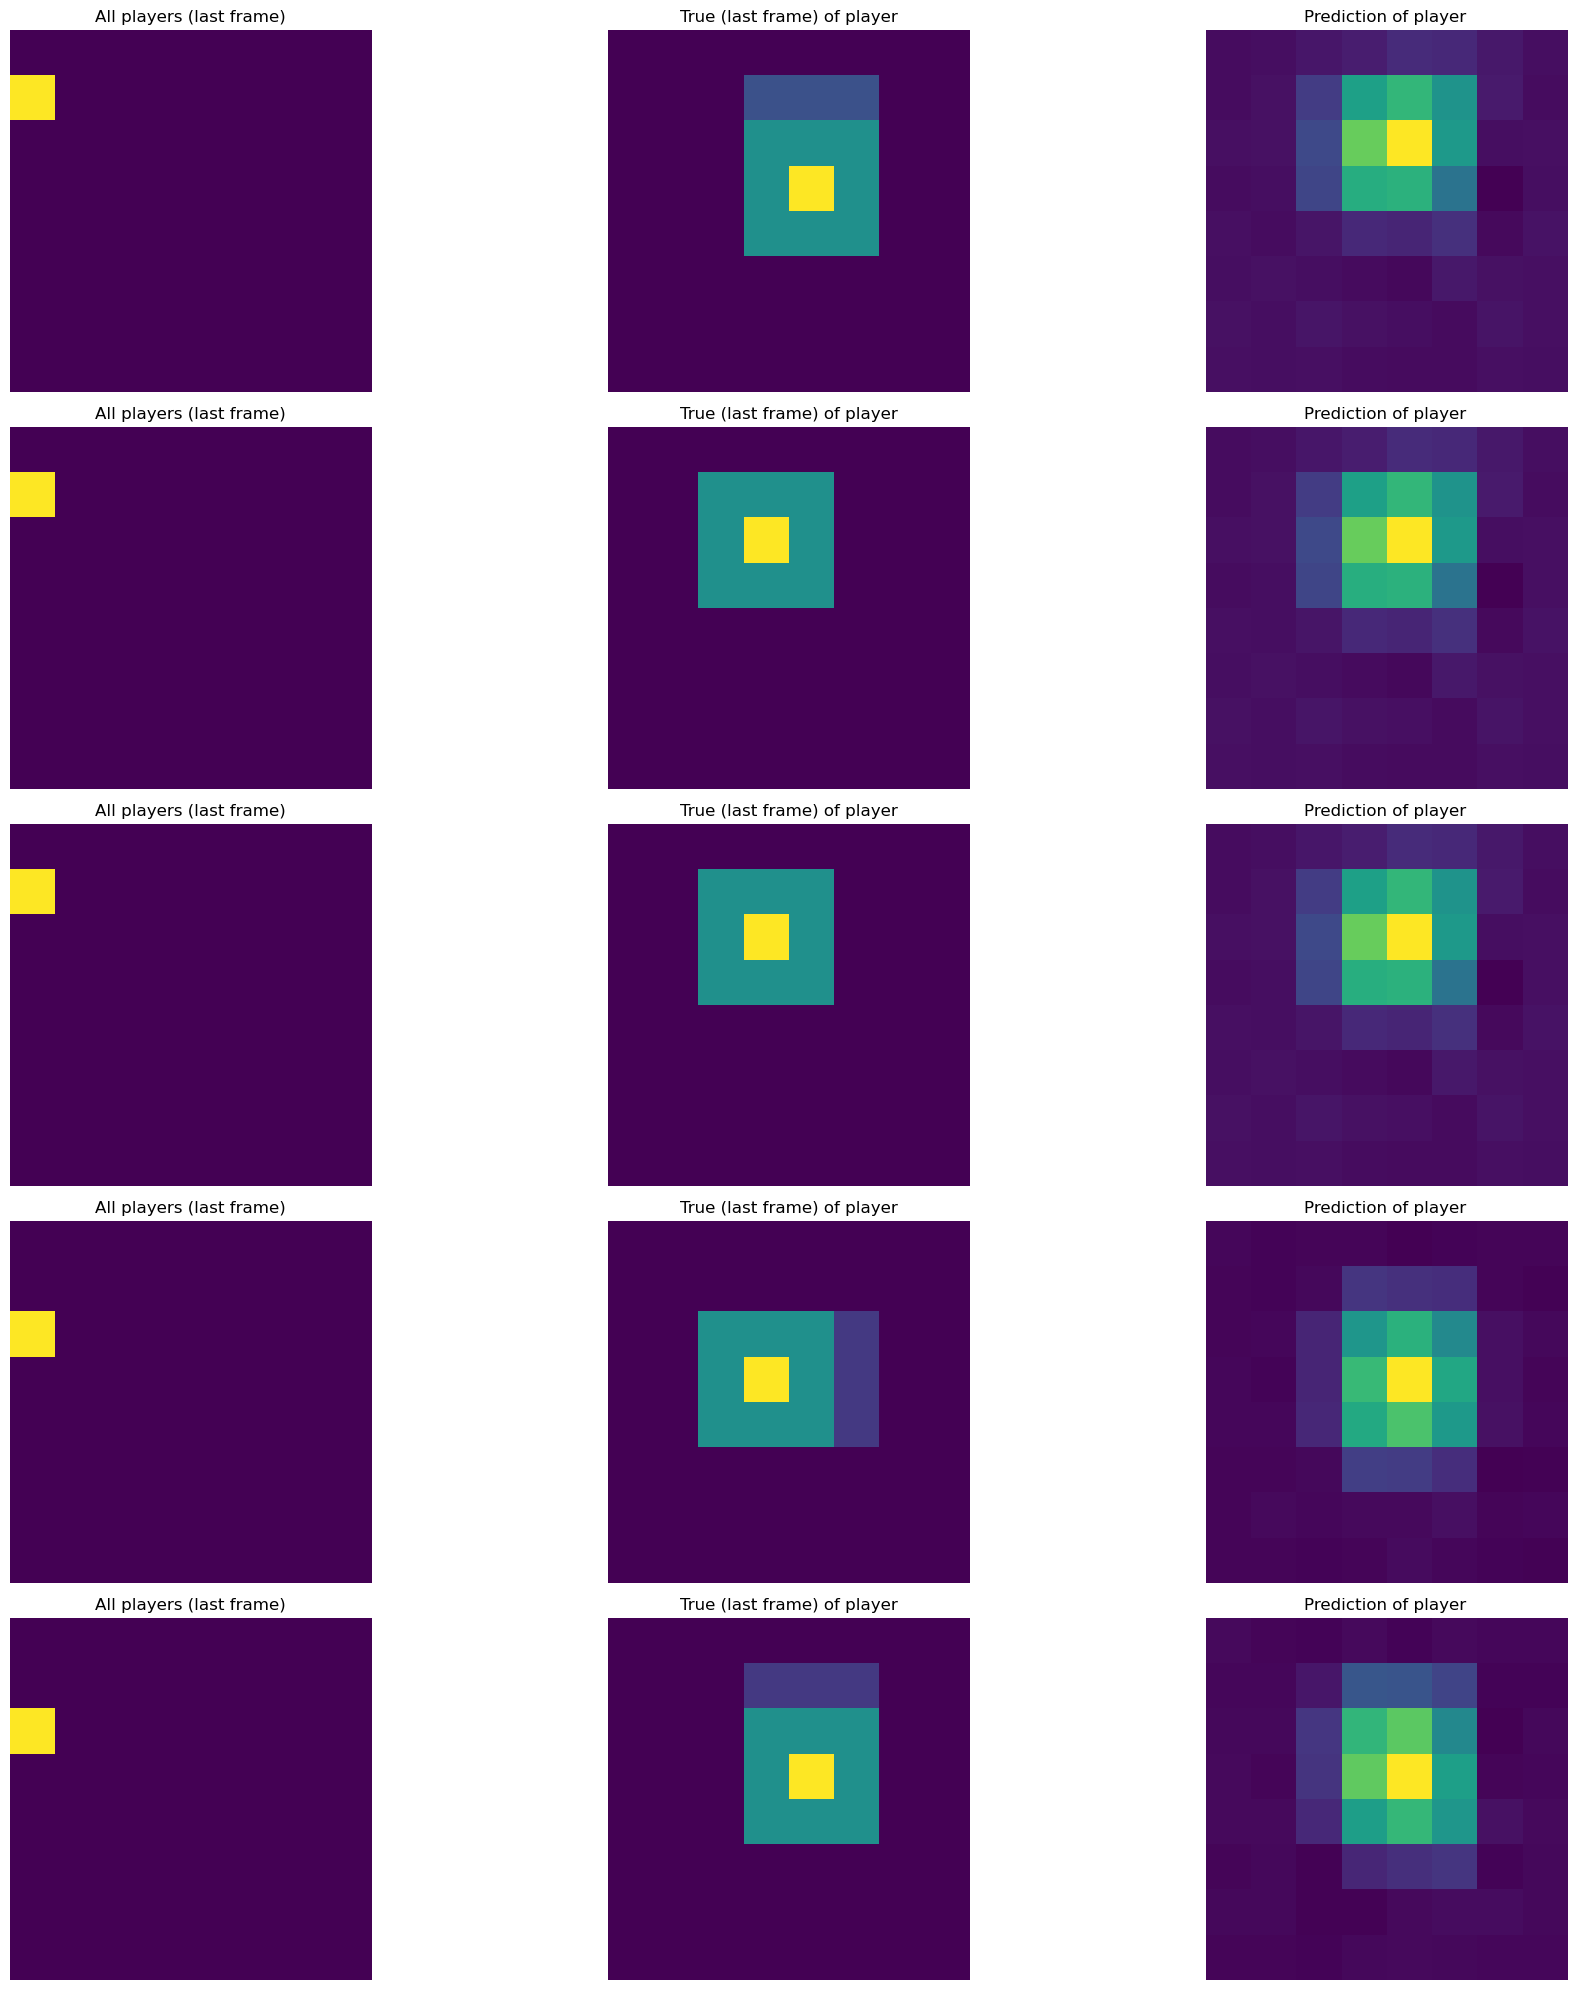

MODELO model1 - ESCENA Scene1
Epoch 1/50
11/11 [==============================] - 2s 77ms/step - loss: 0.0391 - mse: 0.0391 - mae: 0.0884 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1101
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.0884 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.0743
Epoch 3/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0699 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0686
Epoch 4/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0627 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0614
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0581 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0639
Epoch 6/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0572 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae:

2/2 [==============================] - 1s 5ms/step


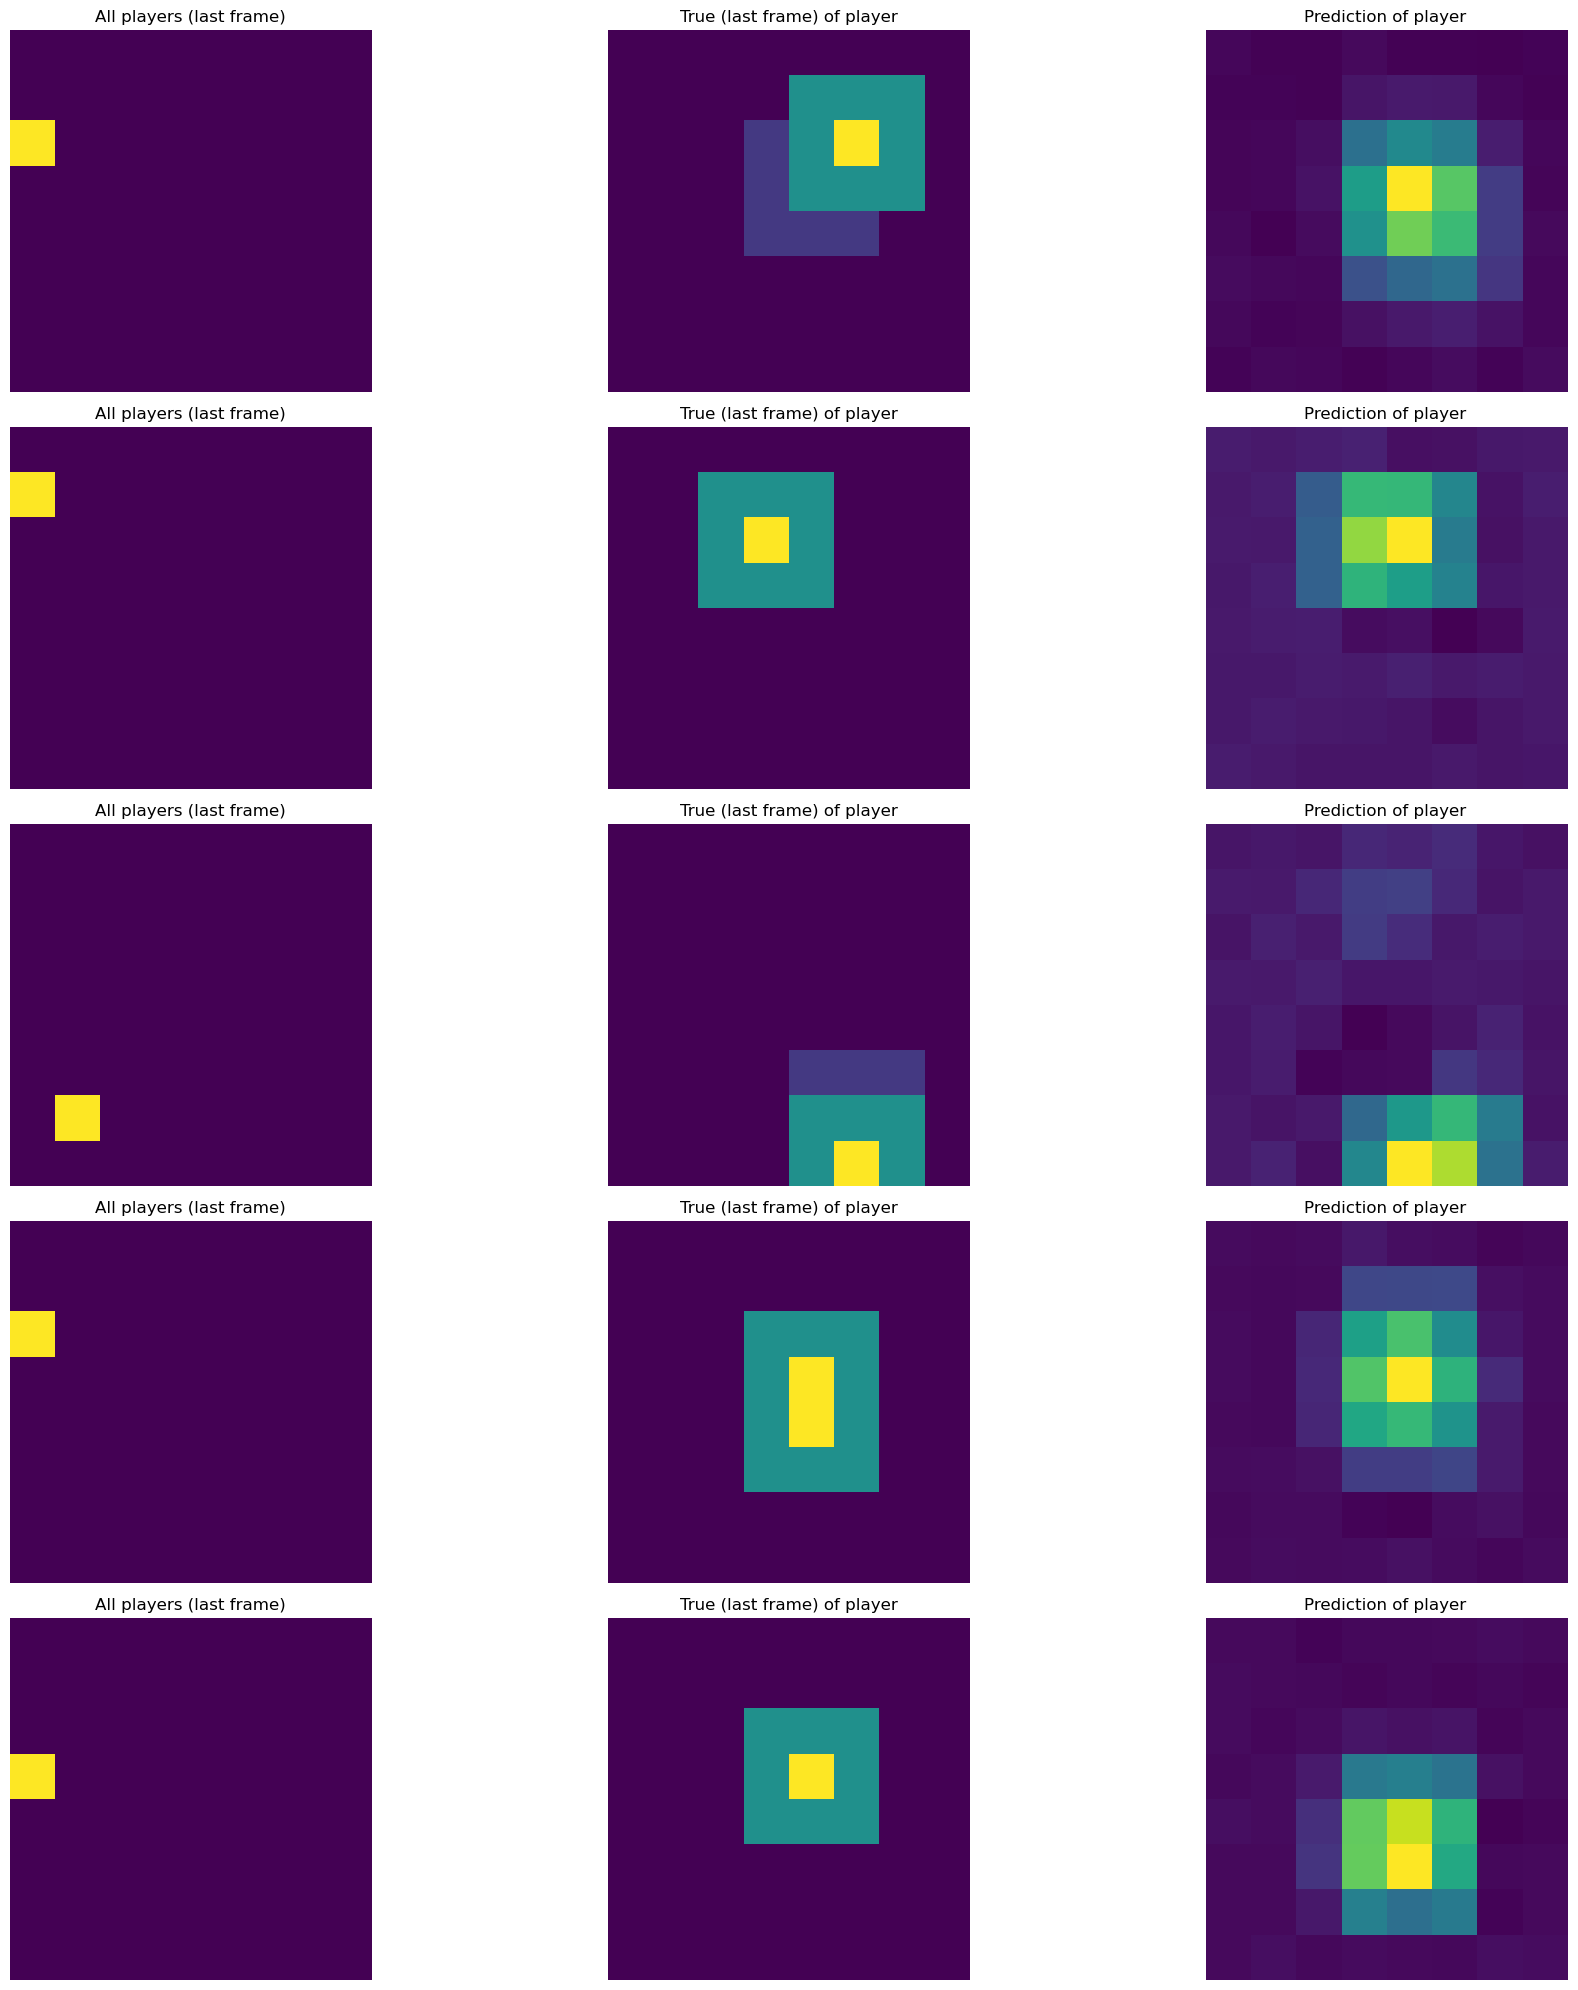

MODELO model2 - ESCENA Scene1
Epoch 1/50
11/11 [==============================] - 3s 108ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.0912 - val_loss: 0.0304 - val_mse: 0.0304 - val_mae: 0.1048
Epoch 2/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0250 - mse: 0.0250 - mae: 0.0888 - val_loss: 0.0188 - val_mse: 0.0188 - val_mae: 0.0723
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.0729 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0766
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0663 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0643
Epoch 5/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0608 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.0637
Epoch 6/50
11/11 [==============================] - 0s 41ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0569 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae

2/2 [==============================] - 1s 8ms/step


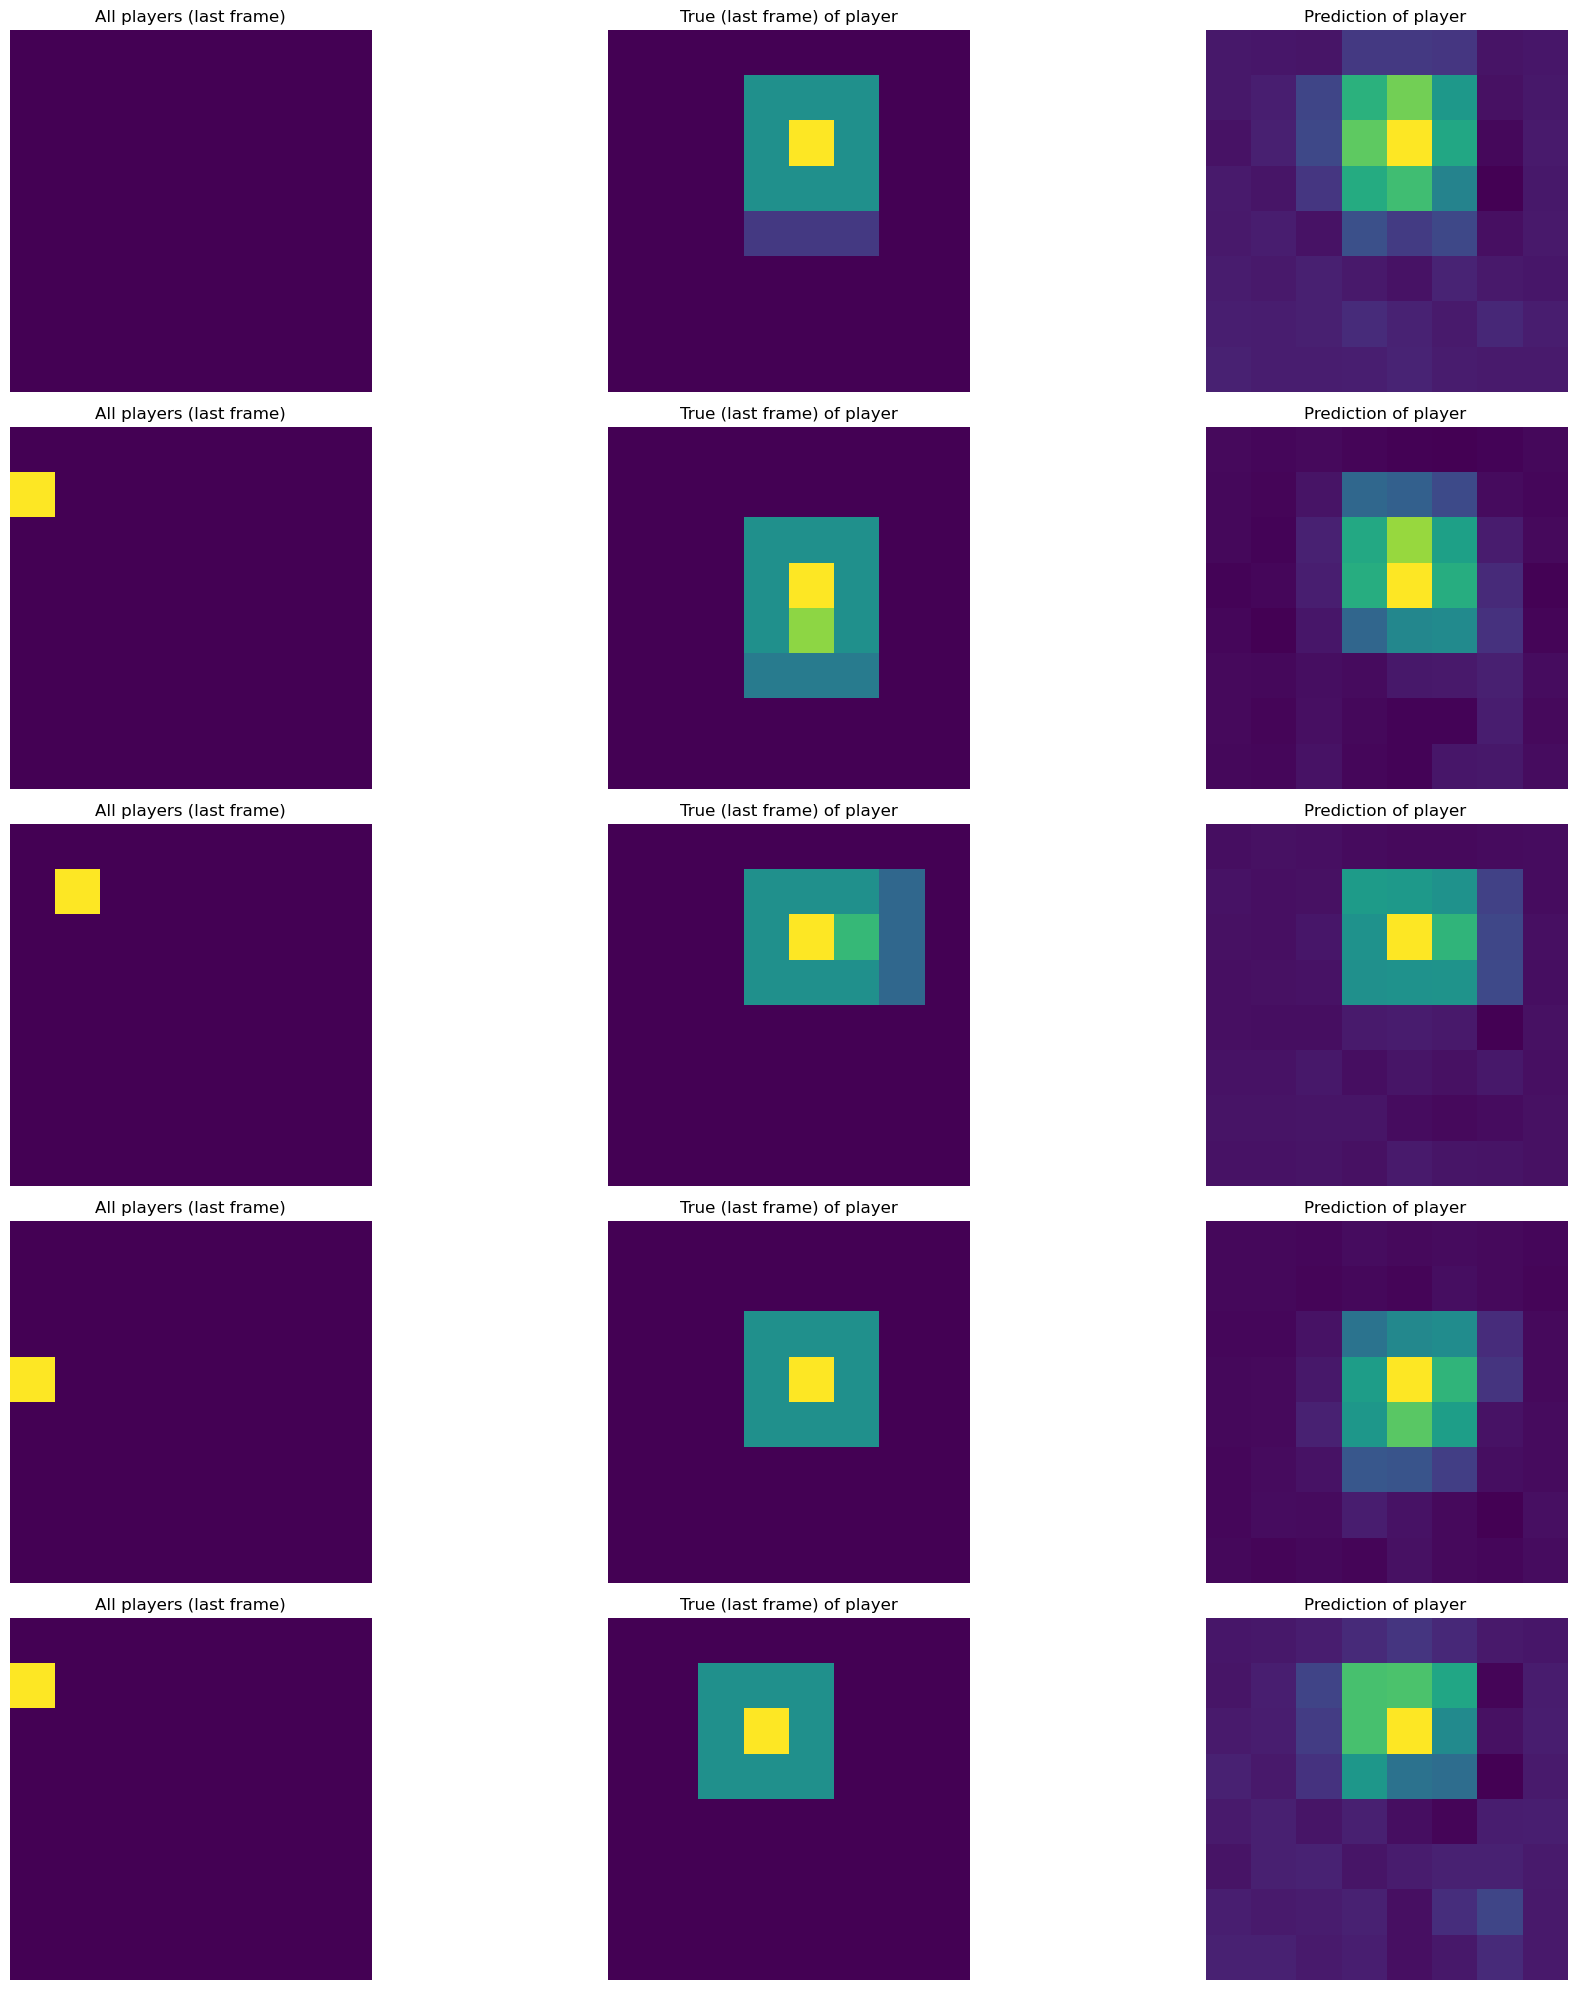

MODELO transf1 - ESCENA Scene1
Epoch 1/50
11/11 [==============================] - 5s 314ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1266 - val_loss: 0.0281 - val_mse: 0.0281 - val_mae: 0.0996
Epoch 2/50
11/11 [==============================] - 3s 228ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1034 - val_loss: 0.0255 - val_mse: 0.0255 - val_mae: 0.0877
Epoch 3/50
11/11 [==============================] - 3s 234ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.0873 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.0773
Epoch 4/50
11/11 [==============================] - 3s 232ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0748 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.0694
Epoch 5/50
11/11 [==============================] - 3s 228ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0646 - val_loss: 0.0178 - val_mse: 0.0178 - val_mae: 0.0679
Epoch 6/50
11/11 [==============================] - 2s 225ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0596 - val_loss: 0.0167 - val_mse: 0.0167 - v

2/2 [==============================] - 0s 62ms/step


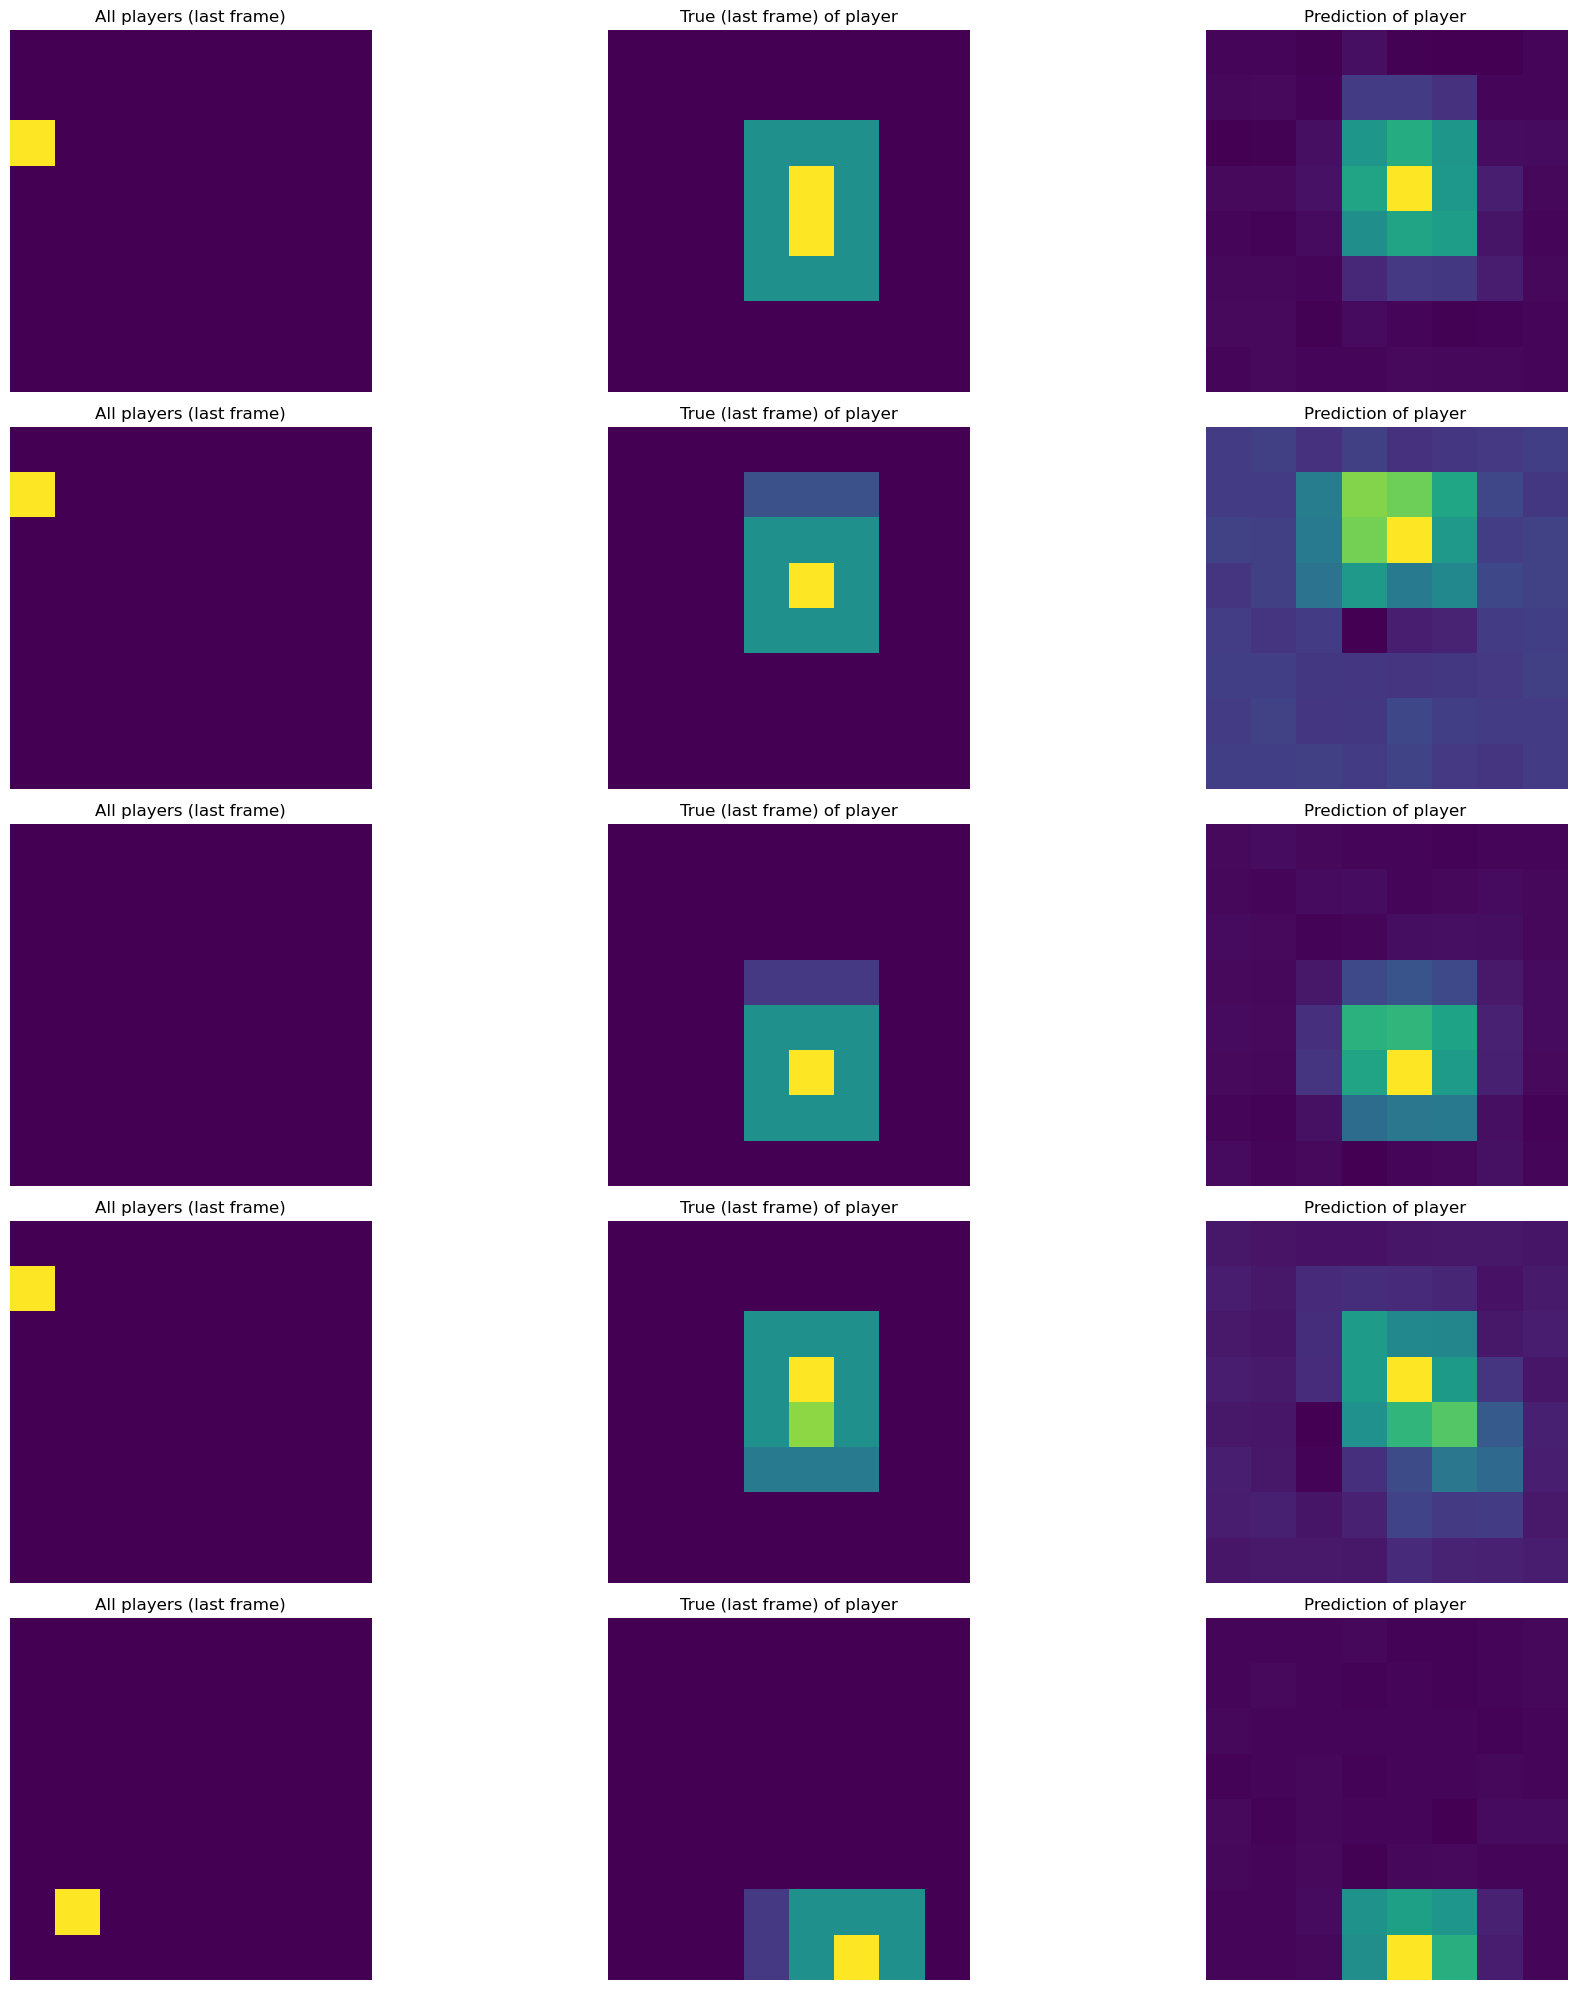

MODELO model0 - ESCENA Scene2
Epoch 1/50
11/11 [==============================] - 8s 215ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.0861 - val_loss: 0.0339 - val_mse: 0.0339 - val_mae: 0.0965
Epoch 2/50
11/11 [==============================] - 2s 138ms/step - loss: 0.0324 - mse: 0.0324 - mae: 0.1083 - val_loss: 0.0276 - val_mse: 0.0276 - val_mae: 0.0974
Epoch 3/50
11/11 [==============================] - 2s 140ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.0948 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.0925
Epoch 4/50
11/11 [==============================] - 2s 138ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.0942 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.0917
Epoch 5/50
11/11 [==============================] - 2s 139ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.0930 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.0891
Epoch 6/50
11/11 [==============================] - 2s 137ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.0855 - val_loss: 0.0213 - val_mse: 0.0213 - va

2/2 [==============================] - 1s 37ms/step


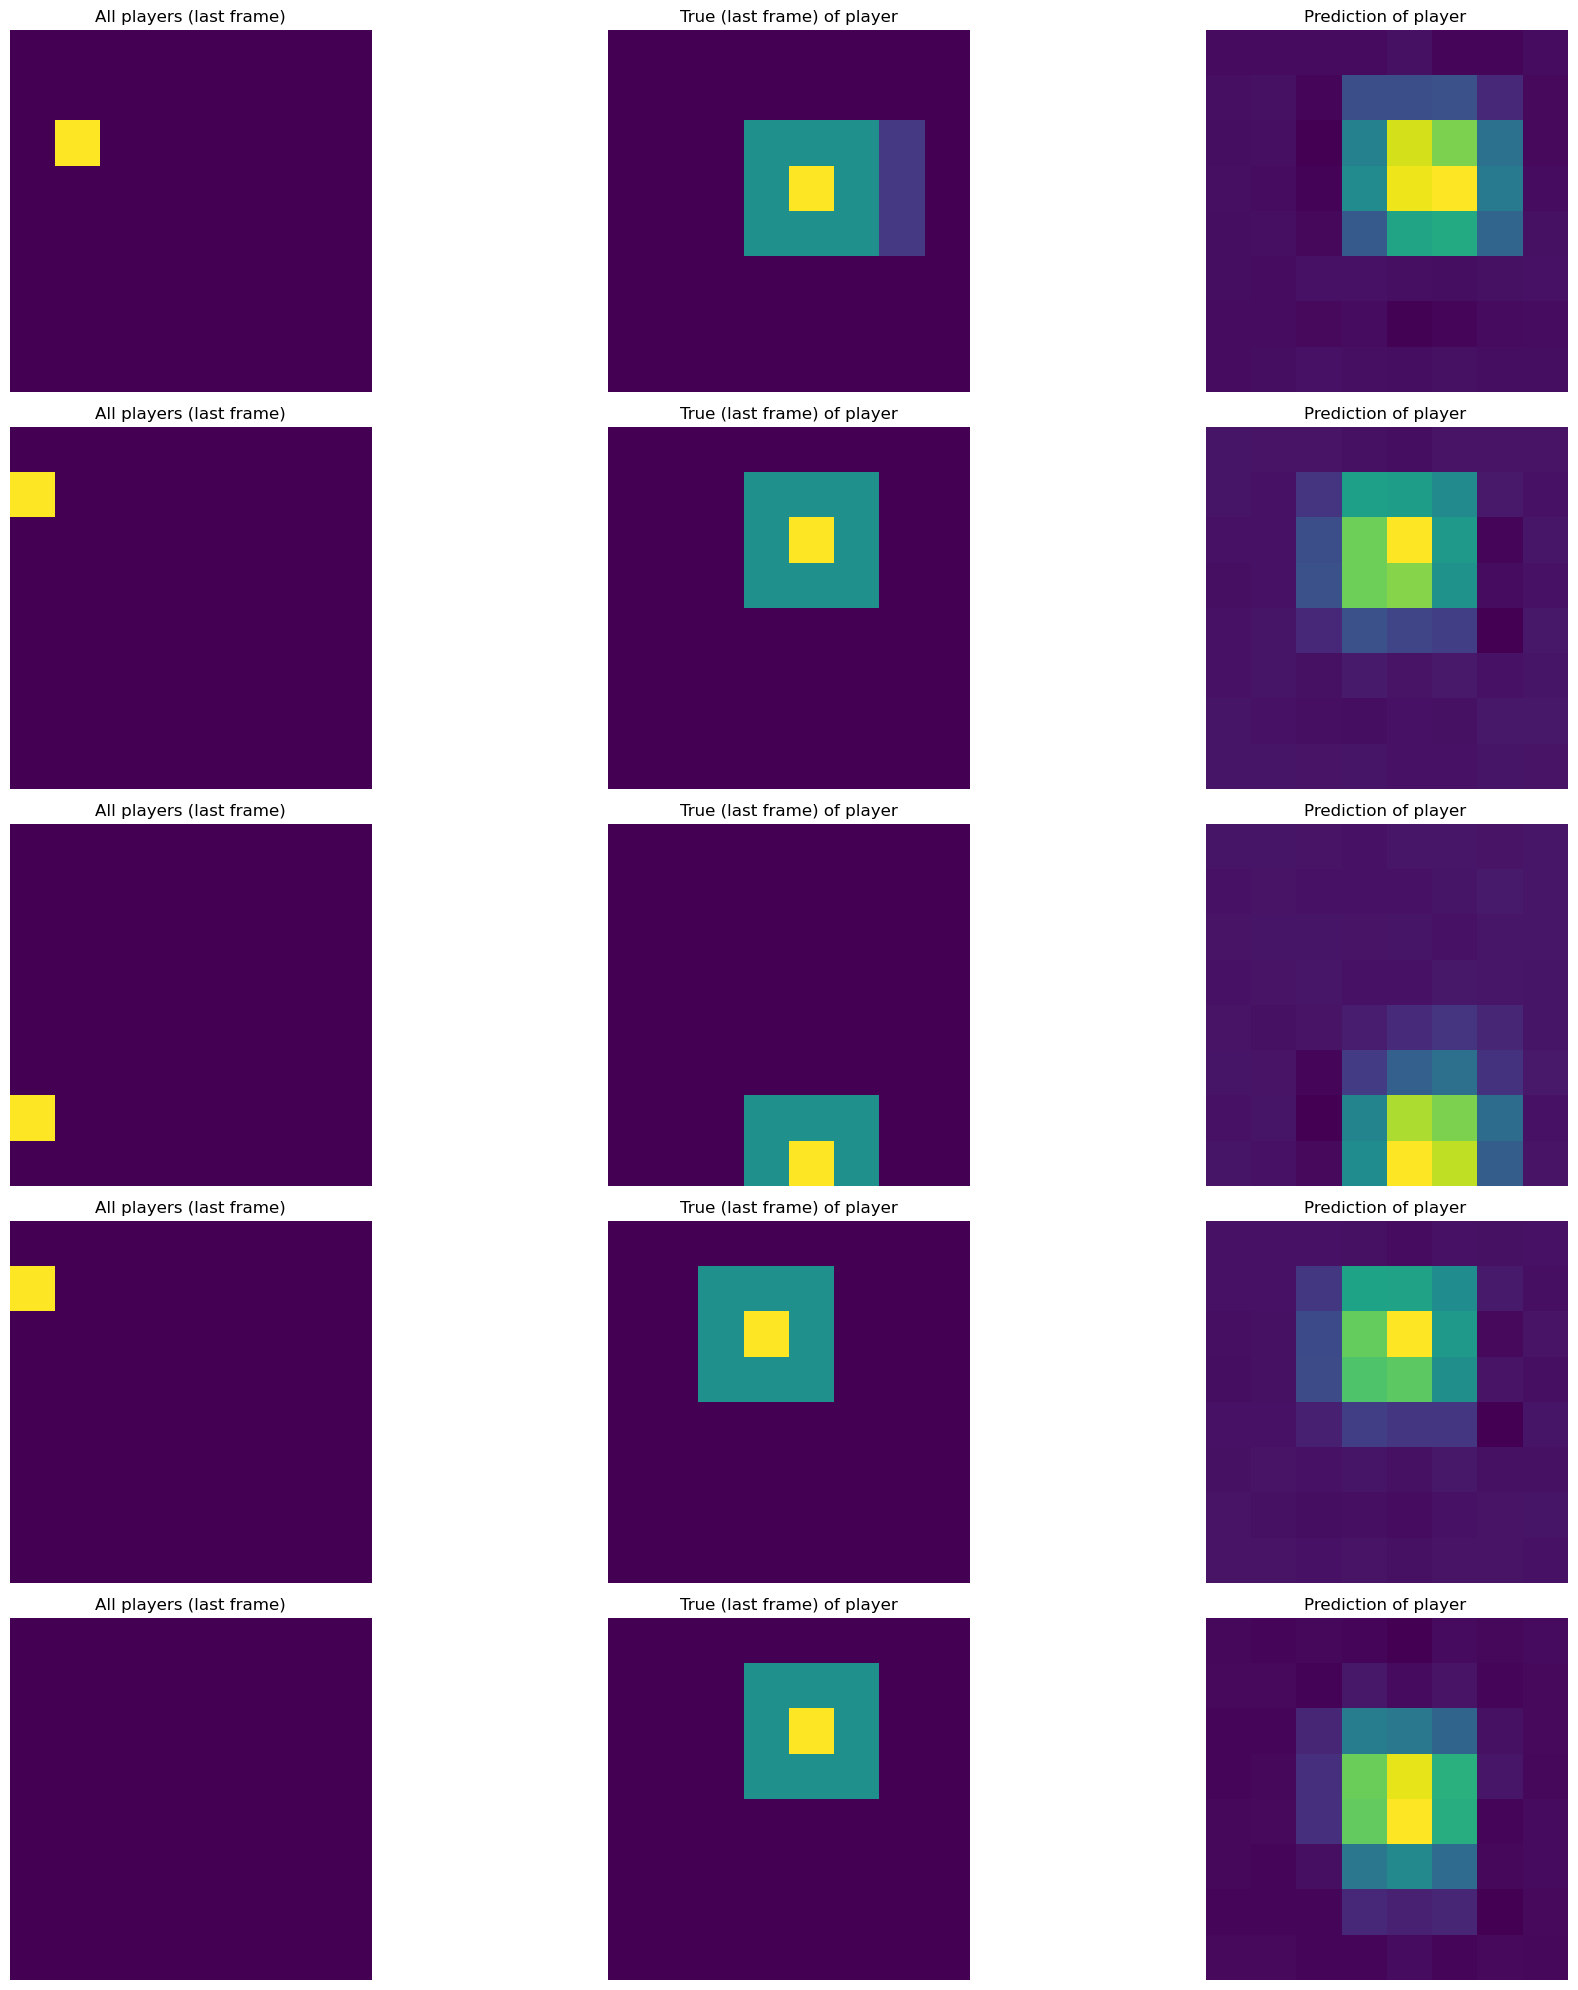

MODELO model1 - ESCENA Scene2
Epoch 1/50
11/11 [==============================] - 3s 141ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.0895 - val_loss: 0.0303 - val_mse: 0.0303 - val_mae: 0.1053
Epoch 2/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.0892 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.0803
Epoch 3/50
11/11 [==============================] - 1s 80ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0696 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.0679
Epoch 4/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0597 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.0702
Epoch 5/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0594 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.0615
Epoch 6/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0565 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae

2/2 [==============================] - 1s 8ms/step


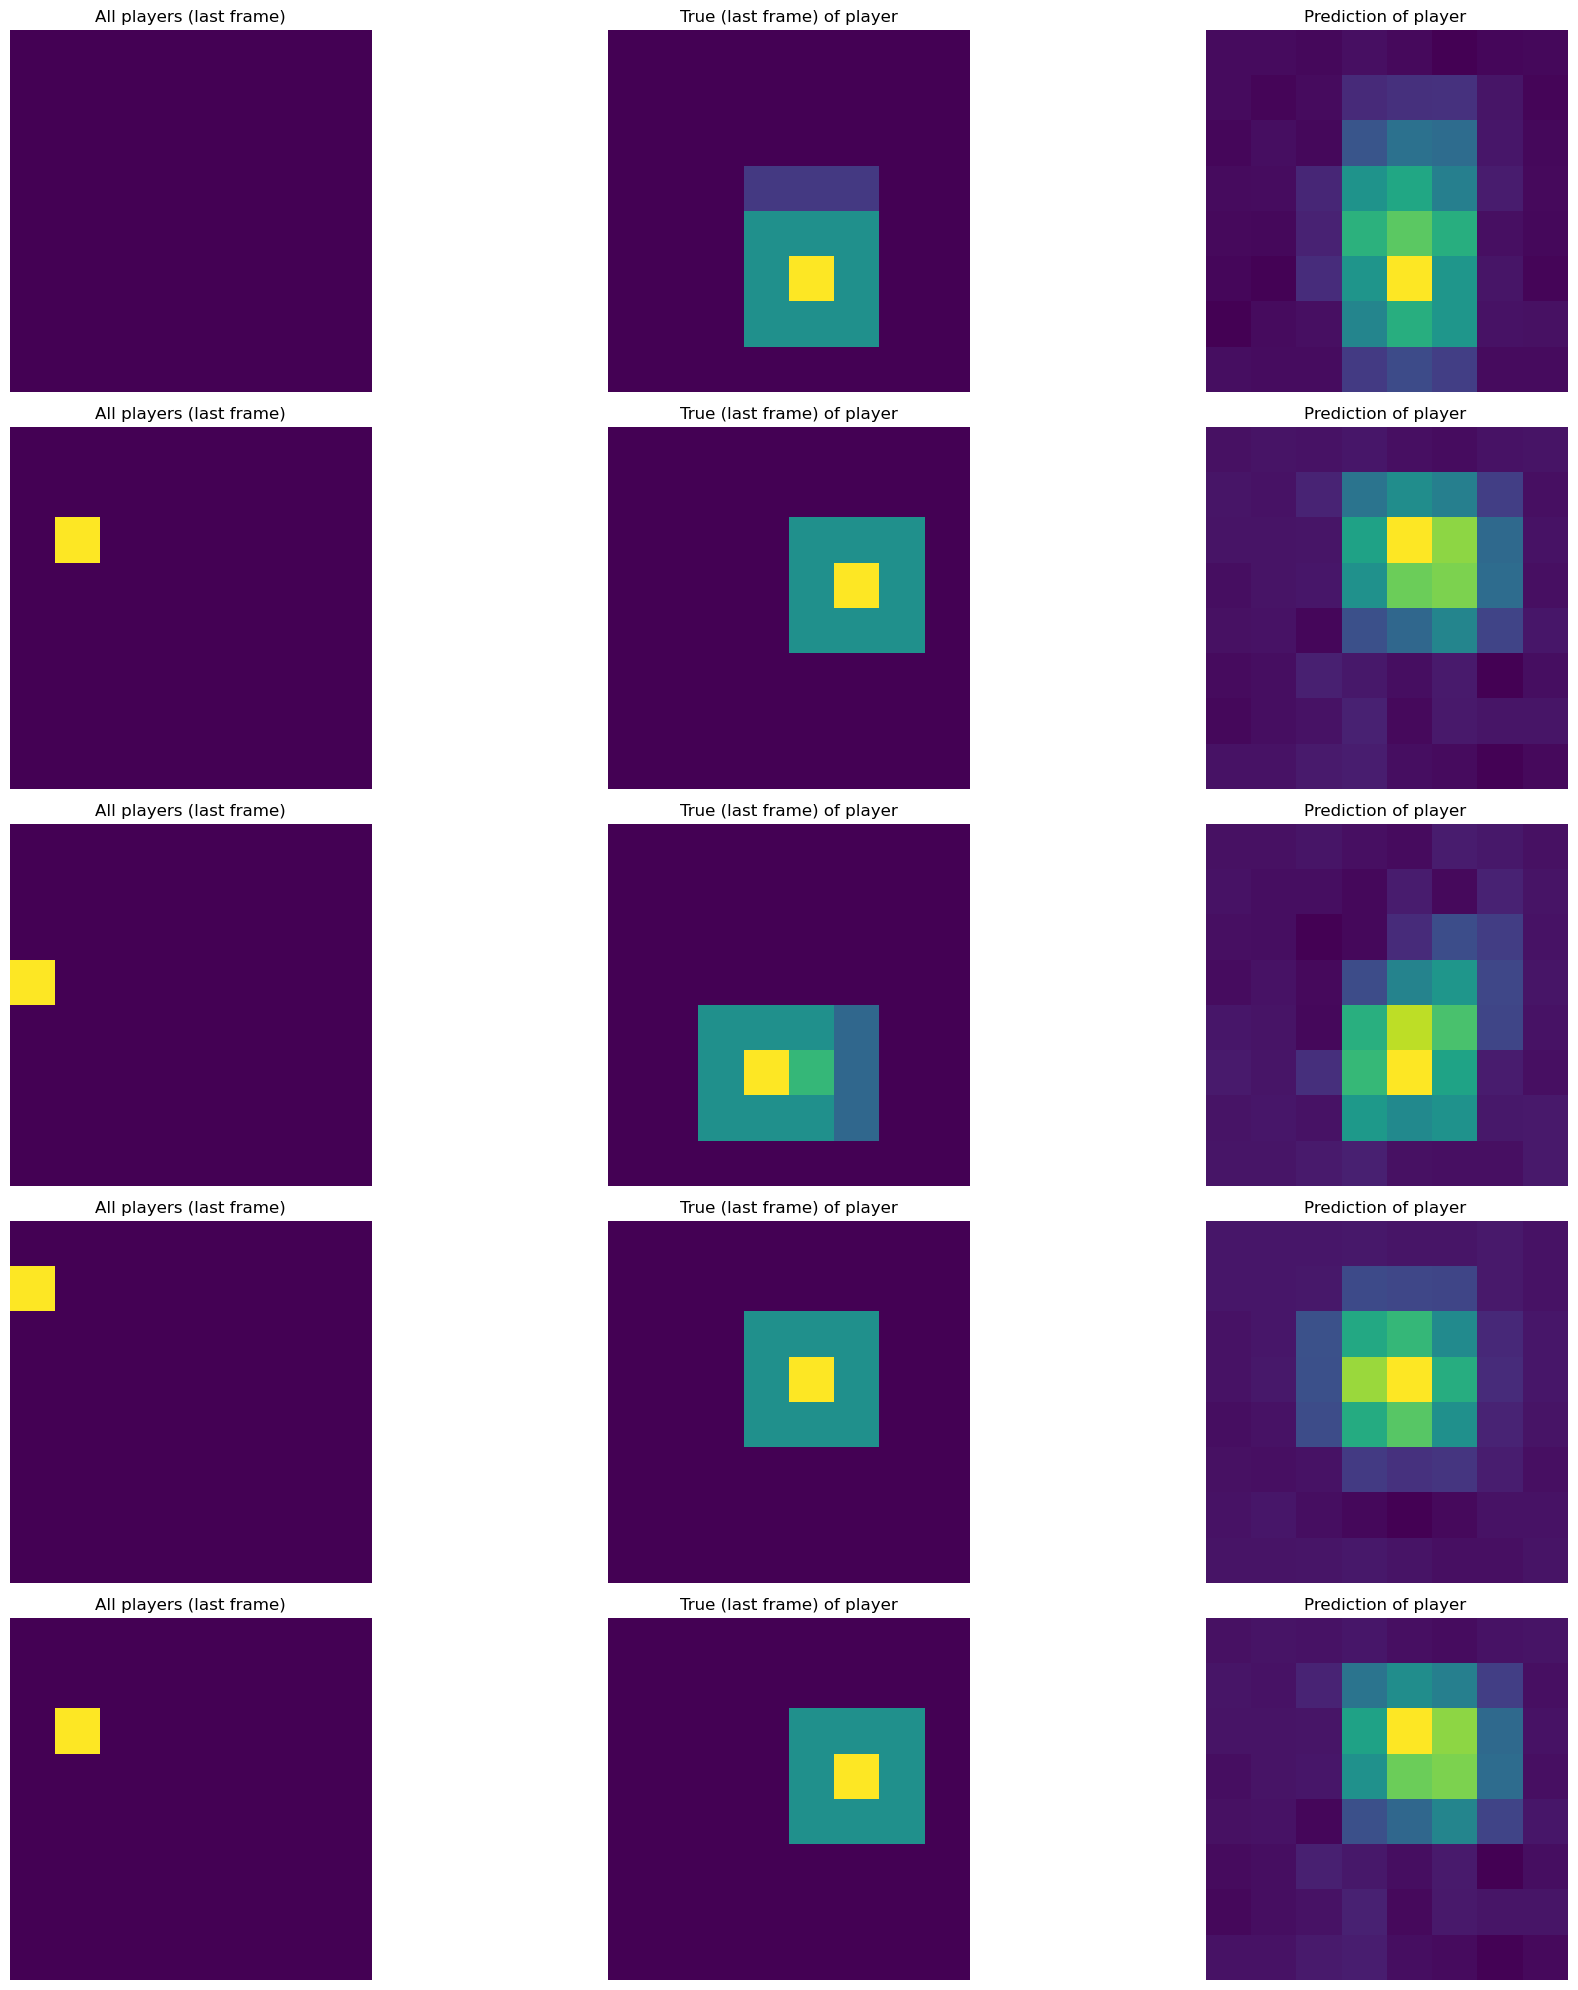

MODELO model2 - ESCENA Scene2
Epoch 1/50
11/11 [==============================] - 4s 194ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.0918 - val_loss: 0.0286 - val_mse: 0.0286 - val_mae: 0.1034
Epoch 2/50
11/11 [==============================] - 1s 125ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.0904 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.0777
Epoch 3/50
11/11 [==============================] - 1s 124ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0721 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0714
Epoch 4/50
11/11 [==============================] - 1s 124ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0660 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0677
Epoch 5/50
11/11 [==============================] - 1s 126ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0630 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0621
Epoch 6/50
11/11 [==============================] - 1s 124ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0584 - val_loss: 0.0171 - val_mse: 0.0171 - va

2/2 [==============================] - 1s 26ms/step


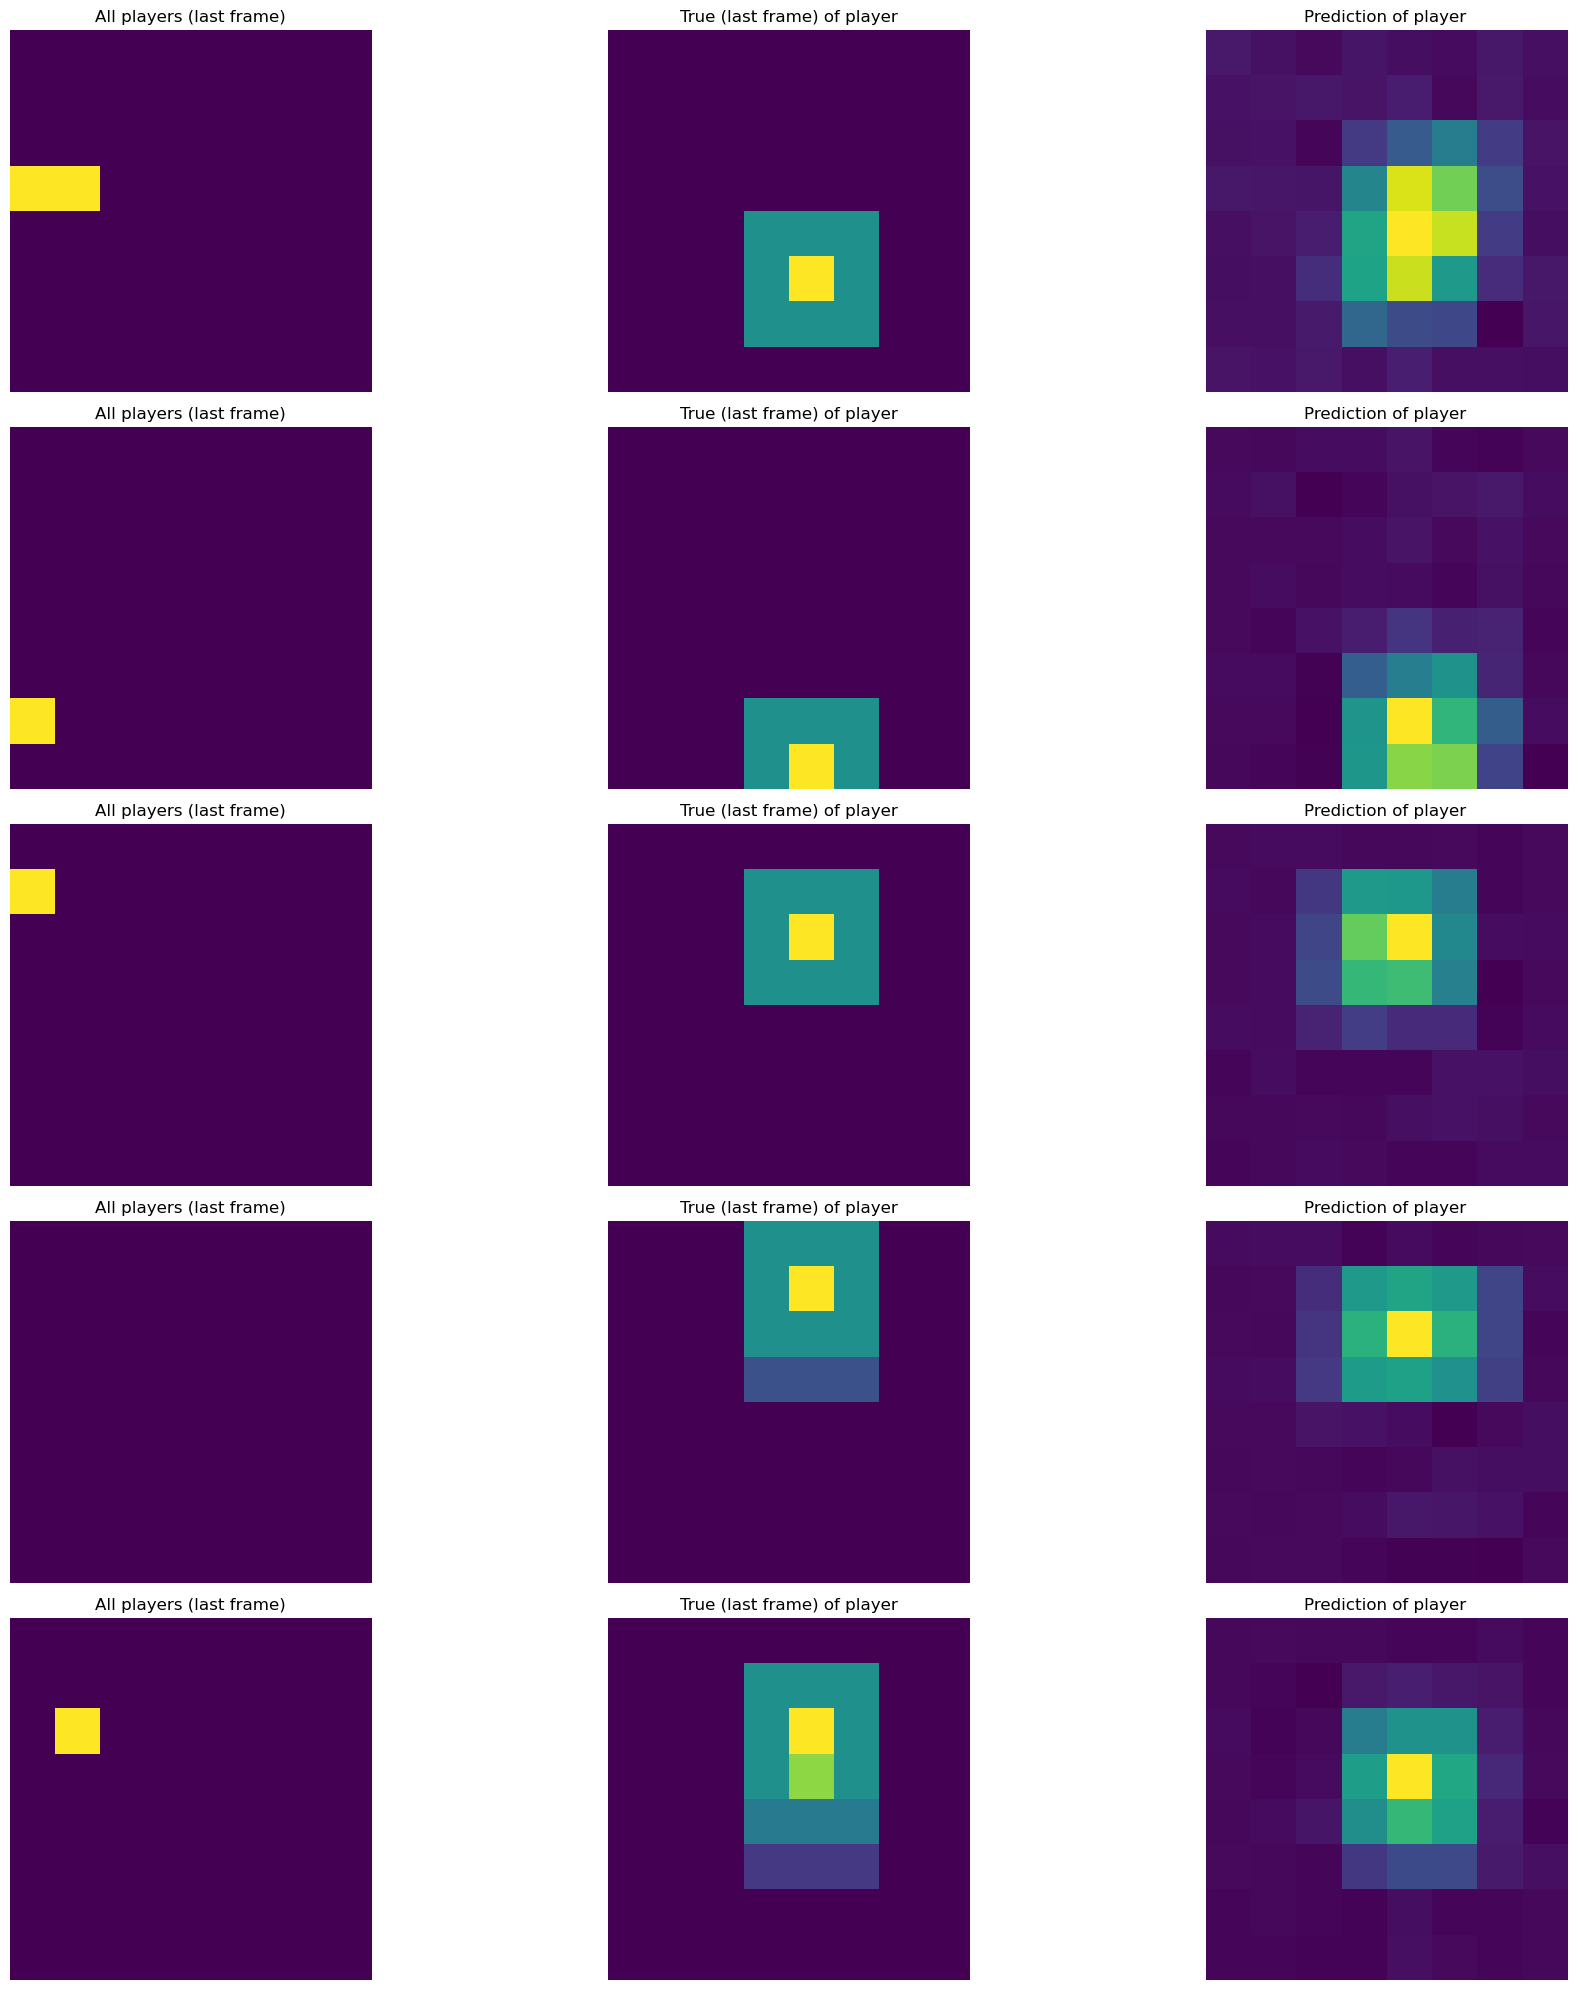

MODELO transf1 - ESCENA Scene2
Epoch 1/50
11/11 [==============================] - 12s 1s/step - loss: 0.0393 - mse: 0.0393 - mae: 0.1236 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1000
Epoch 2/50
11/11 [==============================] - 11s 957ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.1020 - val_loss: 0.0247 - val_mse: 0.0247 - val_mae: 0.0959
Epoch 3/50
11/11 [==============================] - 11s 956ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.0895 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0811
Epoch 4/50
11/11 [==============================] - 11s 959ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0750 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0710
Epoch 5/50
11/11 [==============================] - 11s 977ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0658 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0671
Epoch 6/50
11/11 [==============================] - 11s 980ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0595 - val_loss: 0.0139 - val_mse: 0.0139 

2/2 [==============================] - 1s 229ms/step


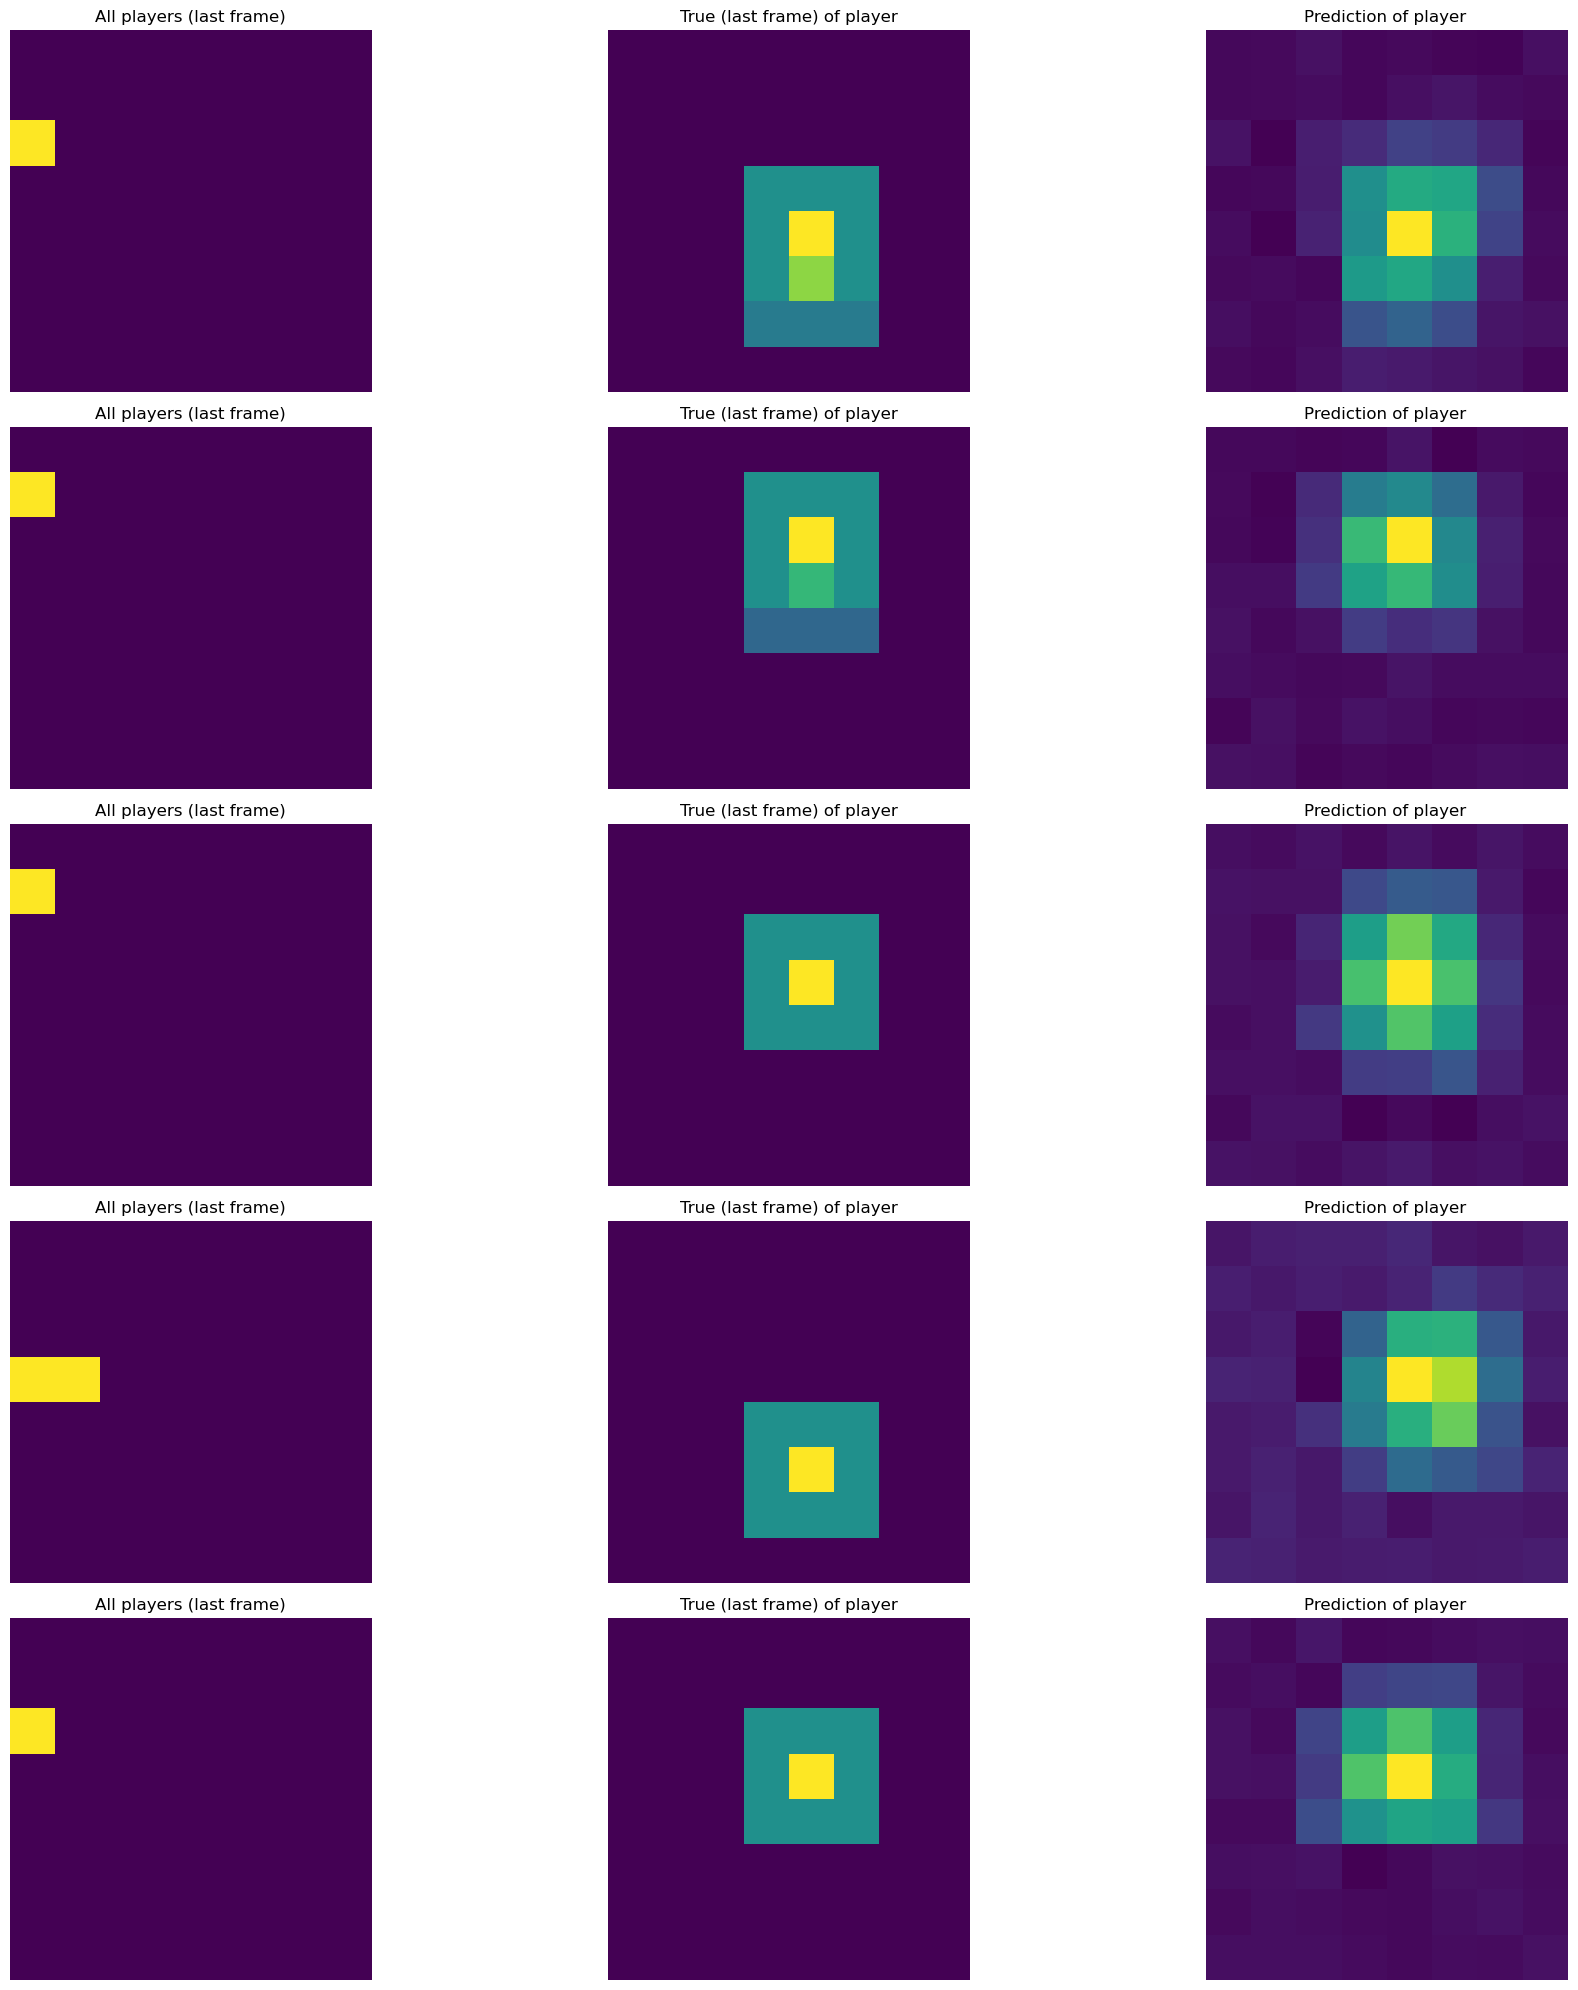

MODELO model0 - ESCENA Scene3
Epoch 1/50
10/10 [==============================] - 7s 169ms/step - loss: 0.0423 - mse: 0.0423 - mae: 0.0849 - val_loss: 0.0370 - val_mse: 0.0370 - val_mae: 0.0972
Epoch 2/50
10/10 [==============================] - 1s 96ms/step - loss: 0.0329 - mse: 0.0329 - mae: 0.1065 - val_loss: 0.0299 - val_mse: 0.0299 - val_mae: 0.1049
Epoch 3/50
10/10 [==============================] - 1s 95ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.0945 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.0946
Epoch 4/50
10/10 [==============================] - 1s 95ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.0942 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.0963
Epoch 5/50
10/10 [==============================] - 1s 96ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.0911 - val_loss: 0.0287 - val_mse: 0.0287 - val_mae: 0.0936
Epoch 6/50
10/10 [==============================] - 1s 95ms/step - loss: 0.0259 - mse: 0.0259 - mae: 0.0880 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae

2/2 [==============================] - 1s 39ms/step


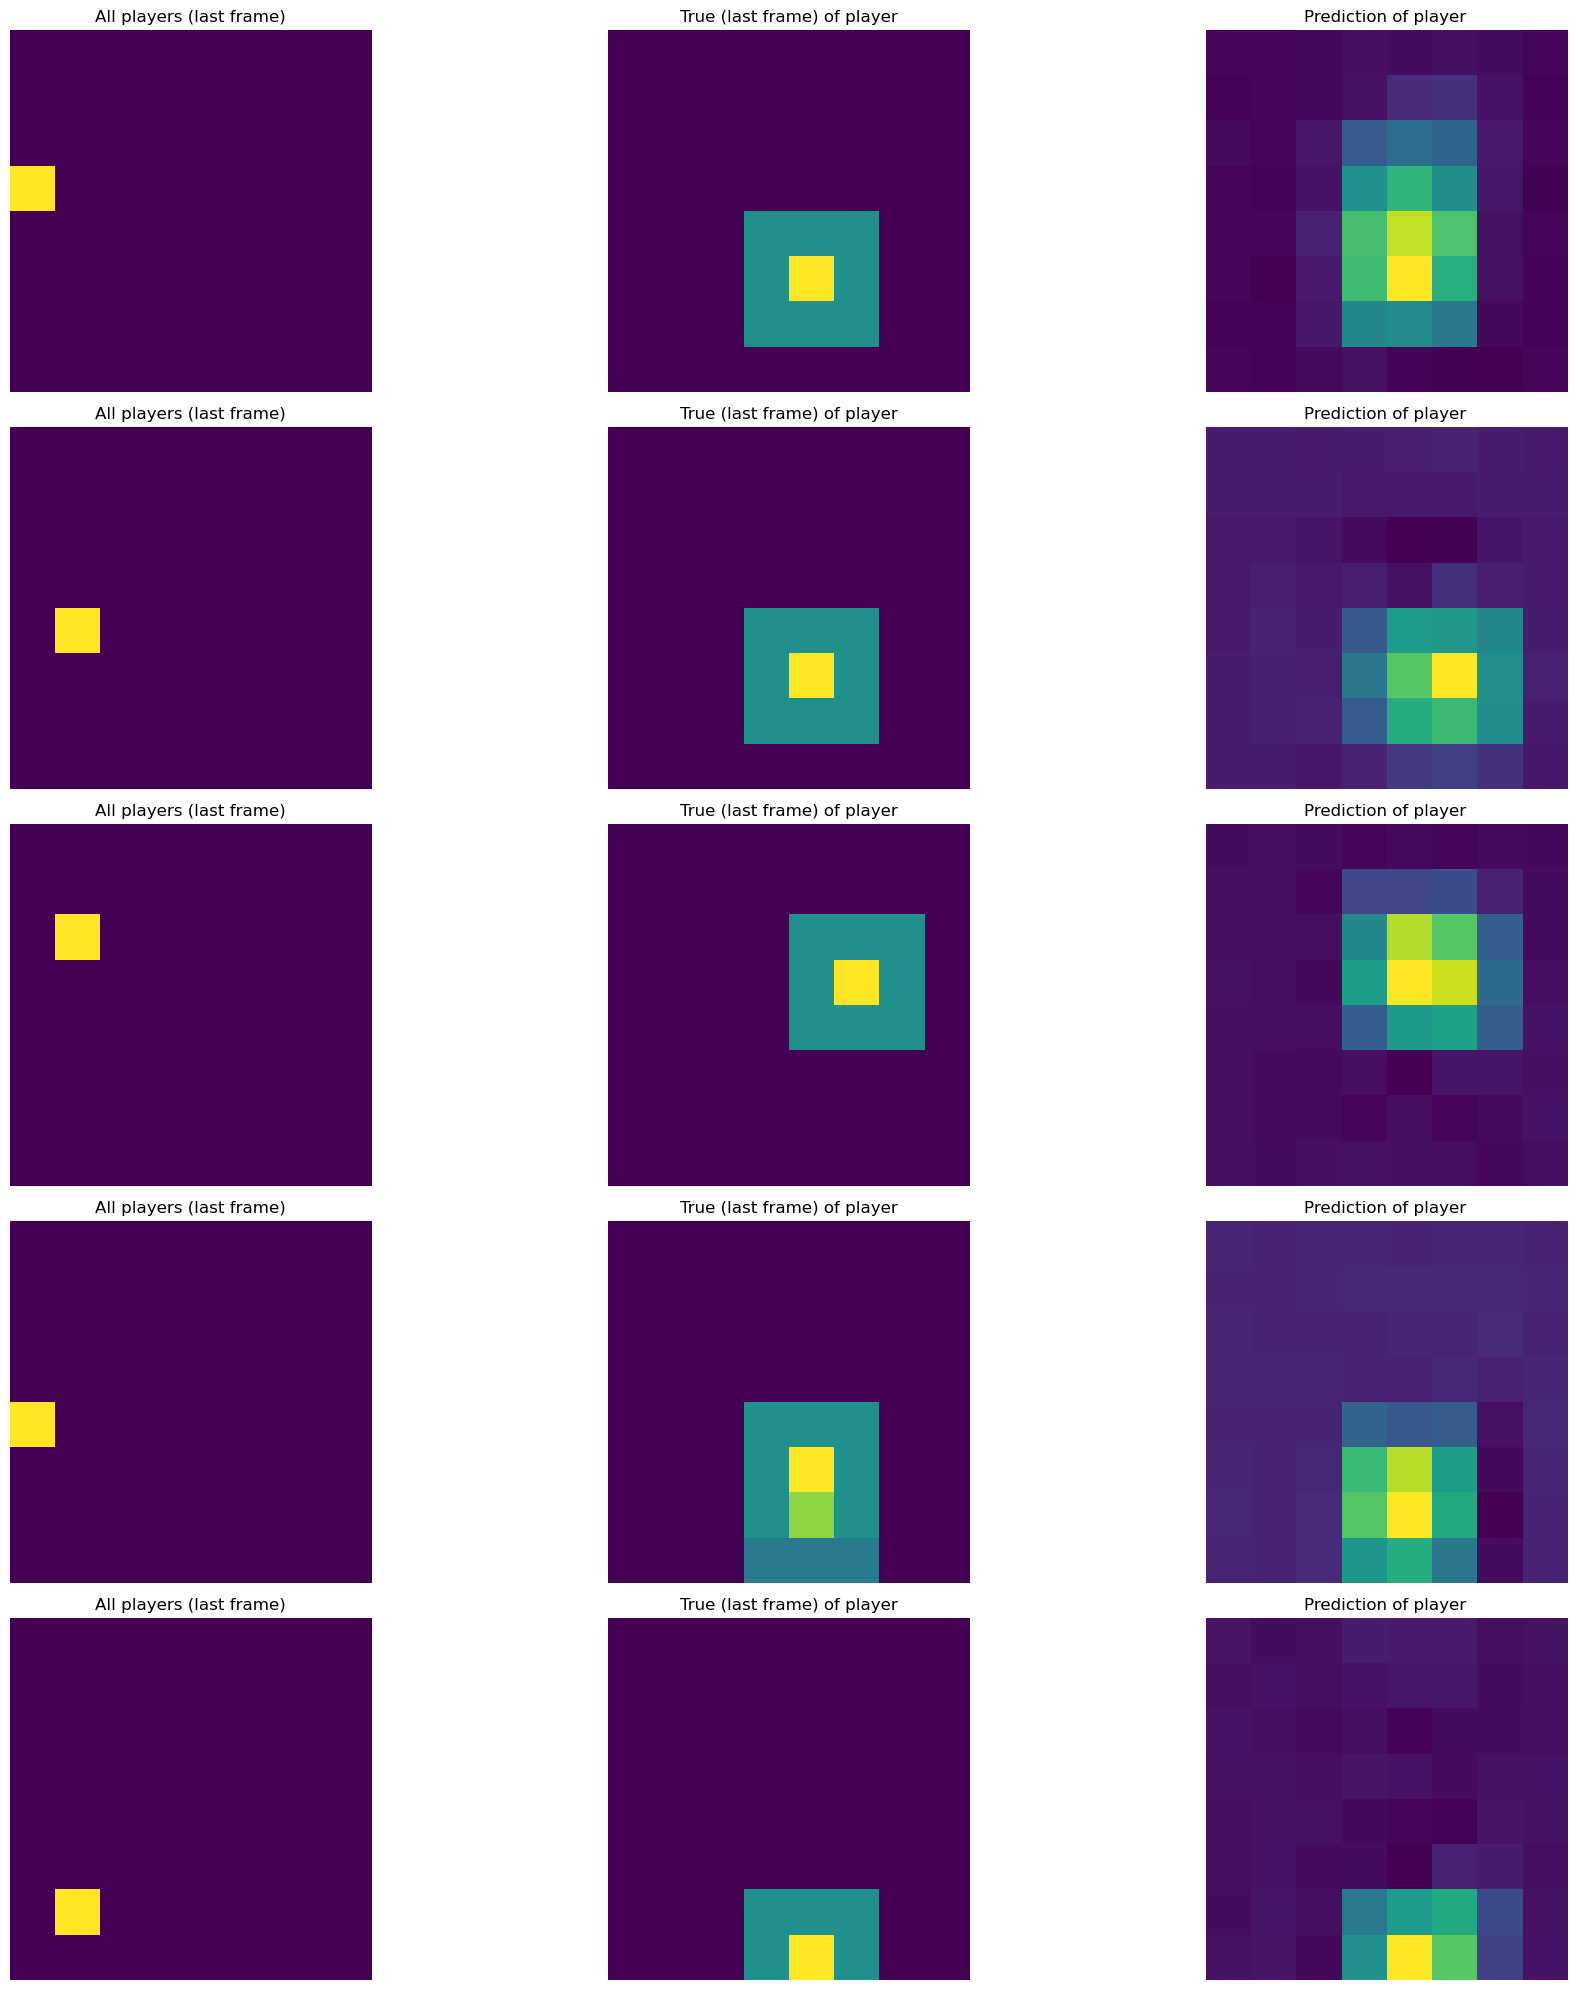

MODELO model1 - ESCENA Scene3
Epoch 1/50
10/10 [==============================] - 3s 128ms/step - loss: 0.0393 - mse: 0.0393 - mae: 0.0869 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.1033
Epoch 2/50
10/10 [==============================] - 1s 64ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.0944 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.0808
Epoch 3/50
10/10 [==============================] - 1s 63ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0737 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0696
Epoch 4/50
10/10 [==============================] - 1s 63ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0659 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0656
Epoch 5/50
10/10 [==============================] - 1s 63ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0613 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0599
Epoch 6/50
10/10 [==============================] - 1s 64ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0579 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae

2/2 [==============================] - 1s 14ms/step


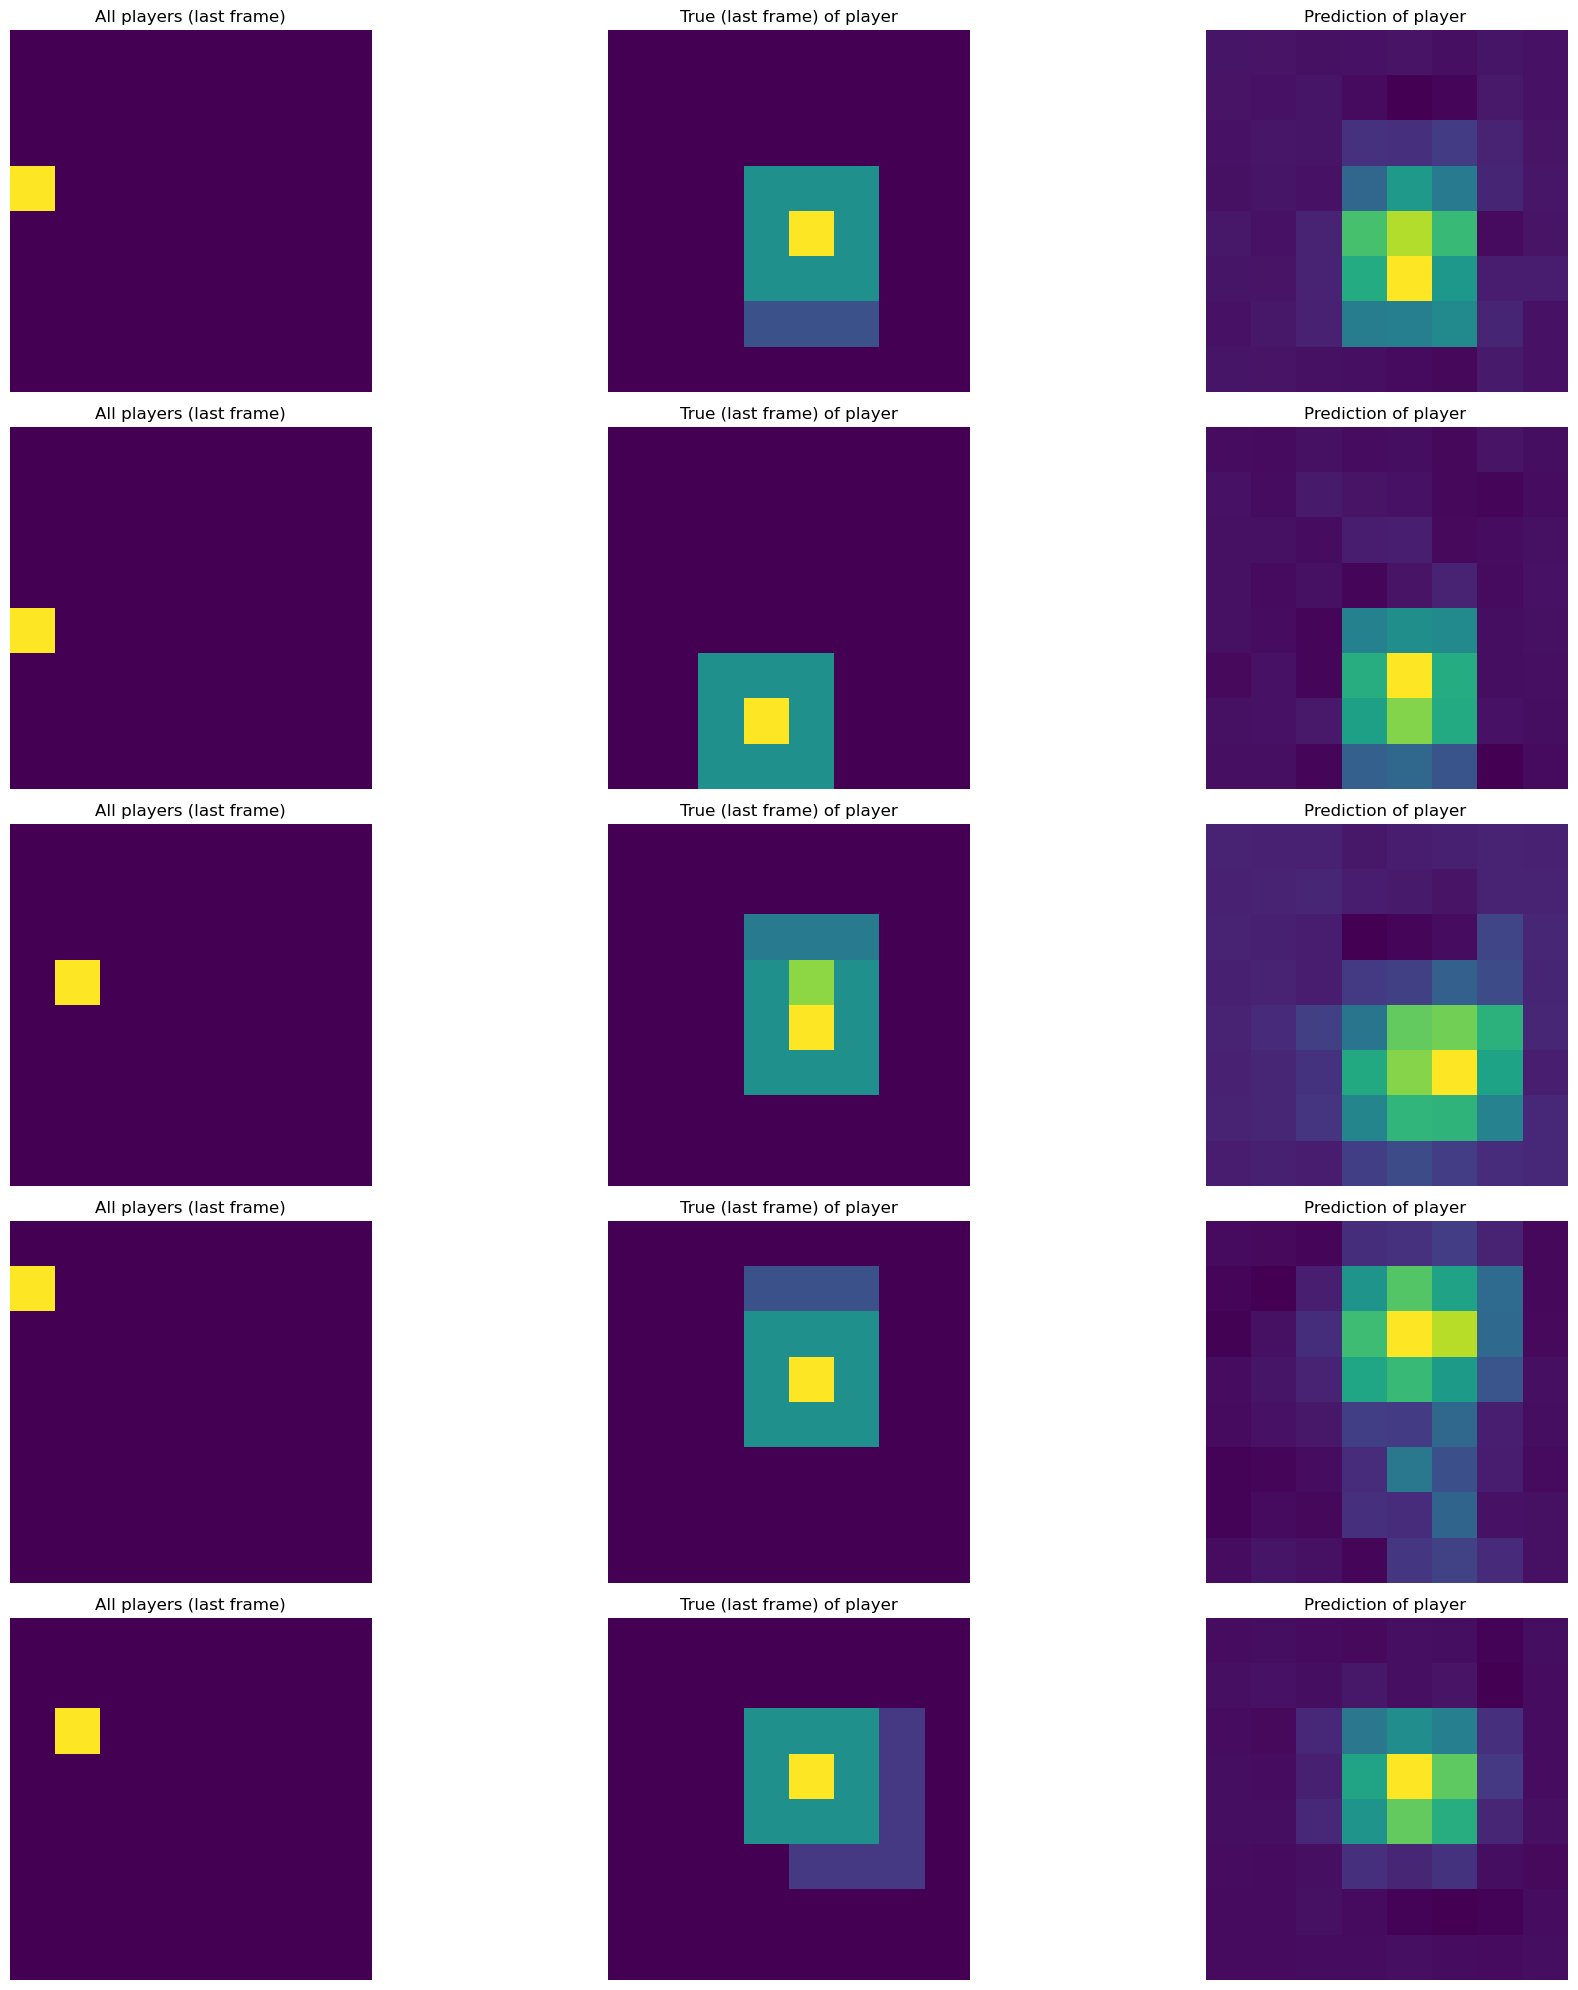

MODELO model2 - ESCENA Scene3
Epoch 1/50
10/10 [==============================] - 3s 185ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.0882 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.1273
Epoch 2/50
10/10 [==============================] - 1s 111ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.0950 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.0860
Epoch 3/50
10/10 [==============================] - 1s 111ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.0784 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.0756
Epoch 4/50
10/10 [==============================] - 1s 111ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.0696 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0679
Epoch 5/50
10/10 [==============================] - 1s 109ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0640 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0666
Epoch 6/50
10/10 [==============================] - 1s 111ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0613 - val_loss: 0.0146 - val_mse: 0.0146 - va

2/2 [==============================] - 1s 34ms/step


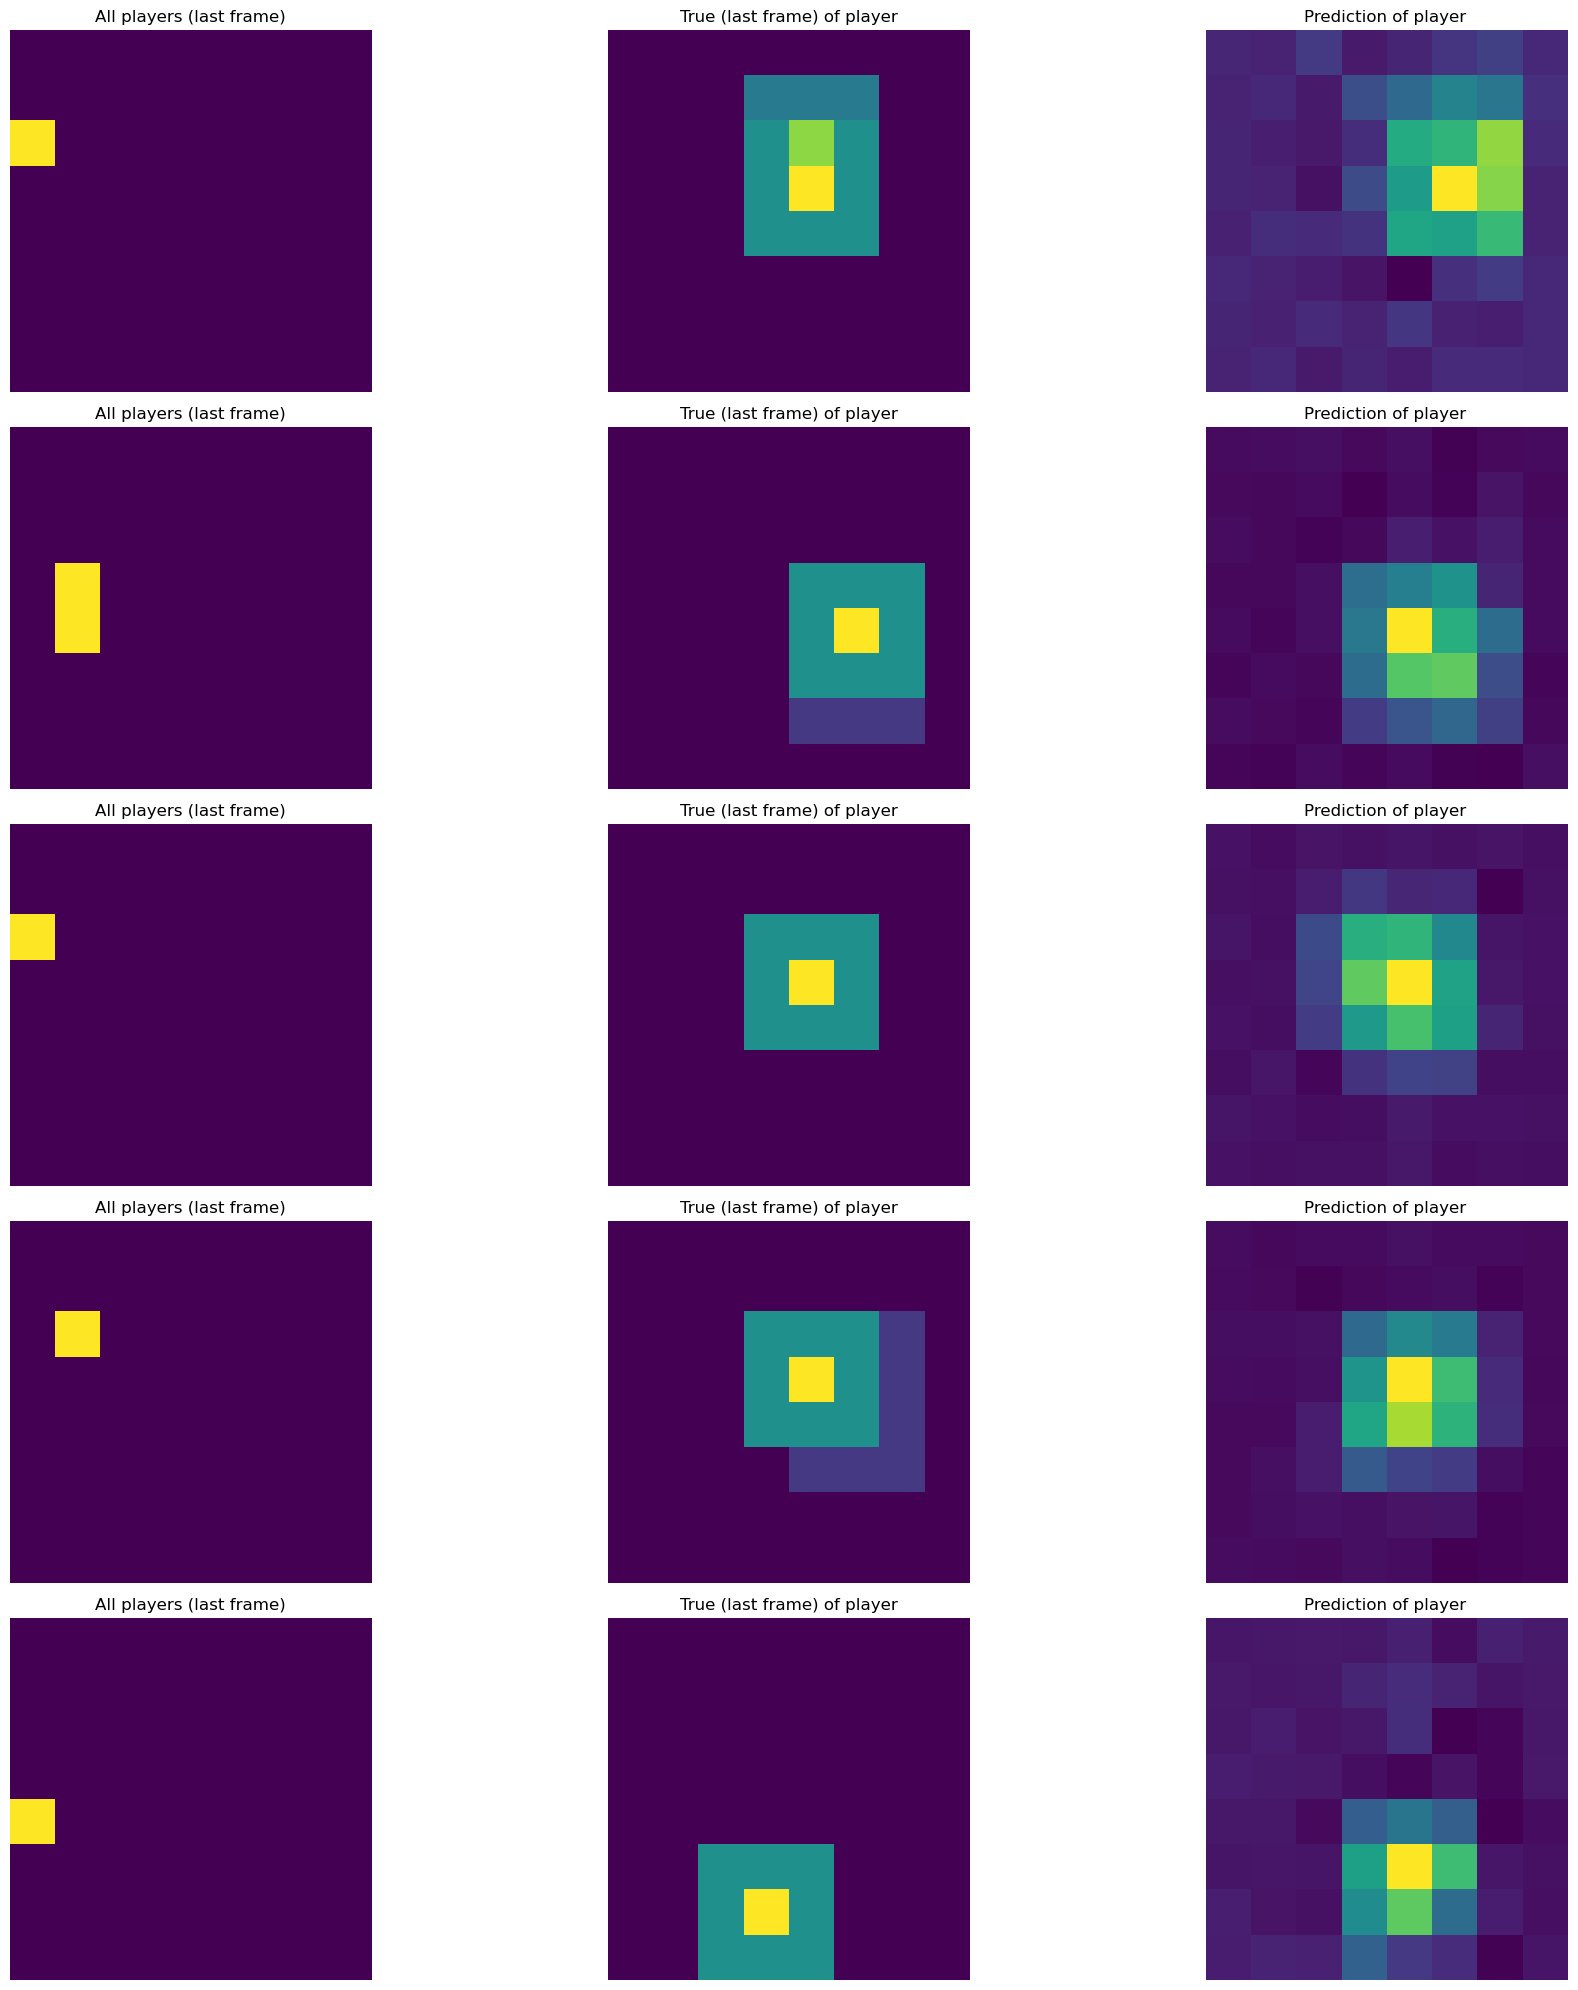

MODELO transf1 - ESCENA Scene3
Epoch 1/50
10/10 [==============================] - 13s 1s/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1245 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1116
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.0267 - mse: 0.0267 - mae: 0.0998 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.1000
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 0.0229 - mse: 0.0229 - mae: 0.0890 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.0887
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0763 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0781
Epoch 5/50
10/10 [==============================] - 12s 1s/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0681 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0708
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0612 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.06

2/2 [==============================] - 2s 640ms/step


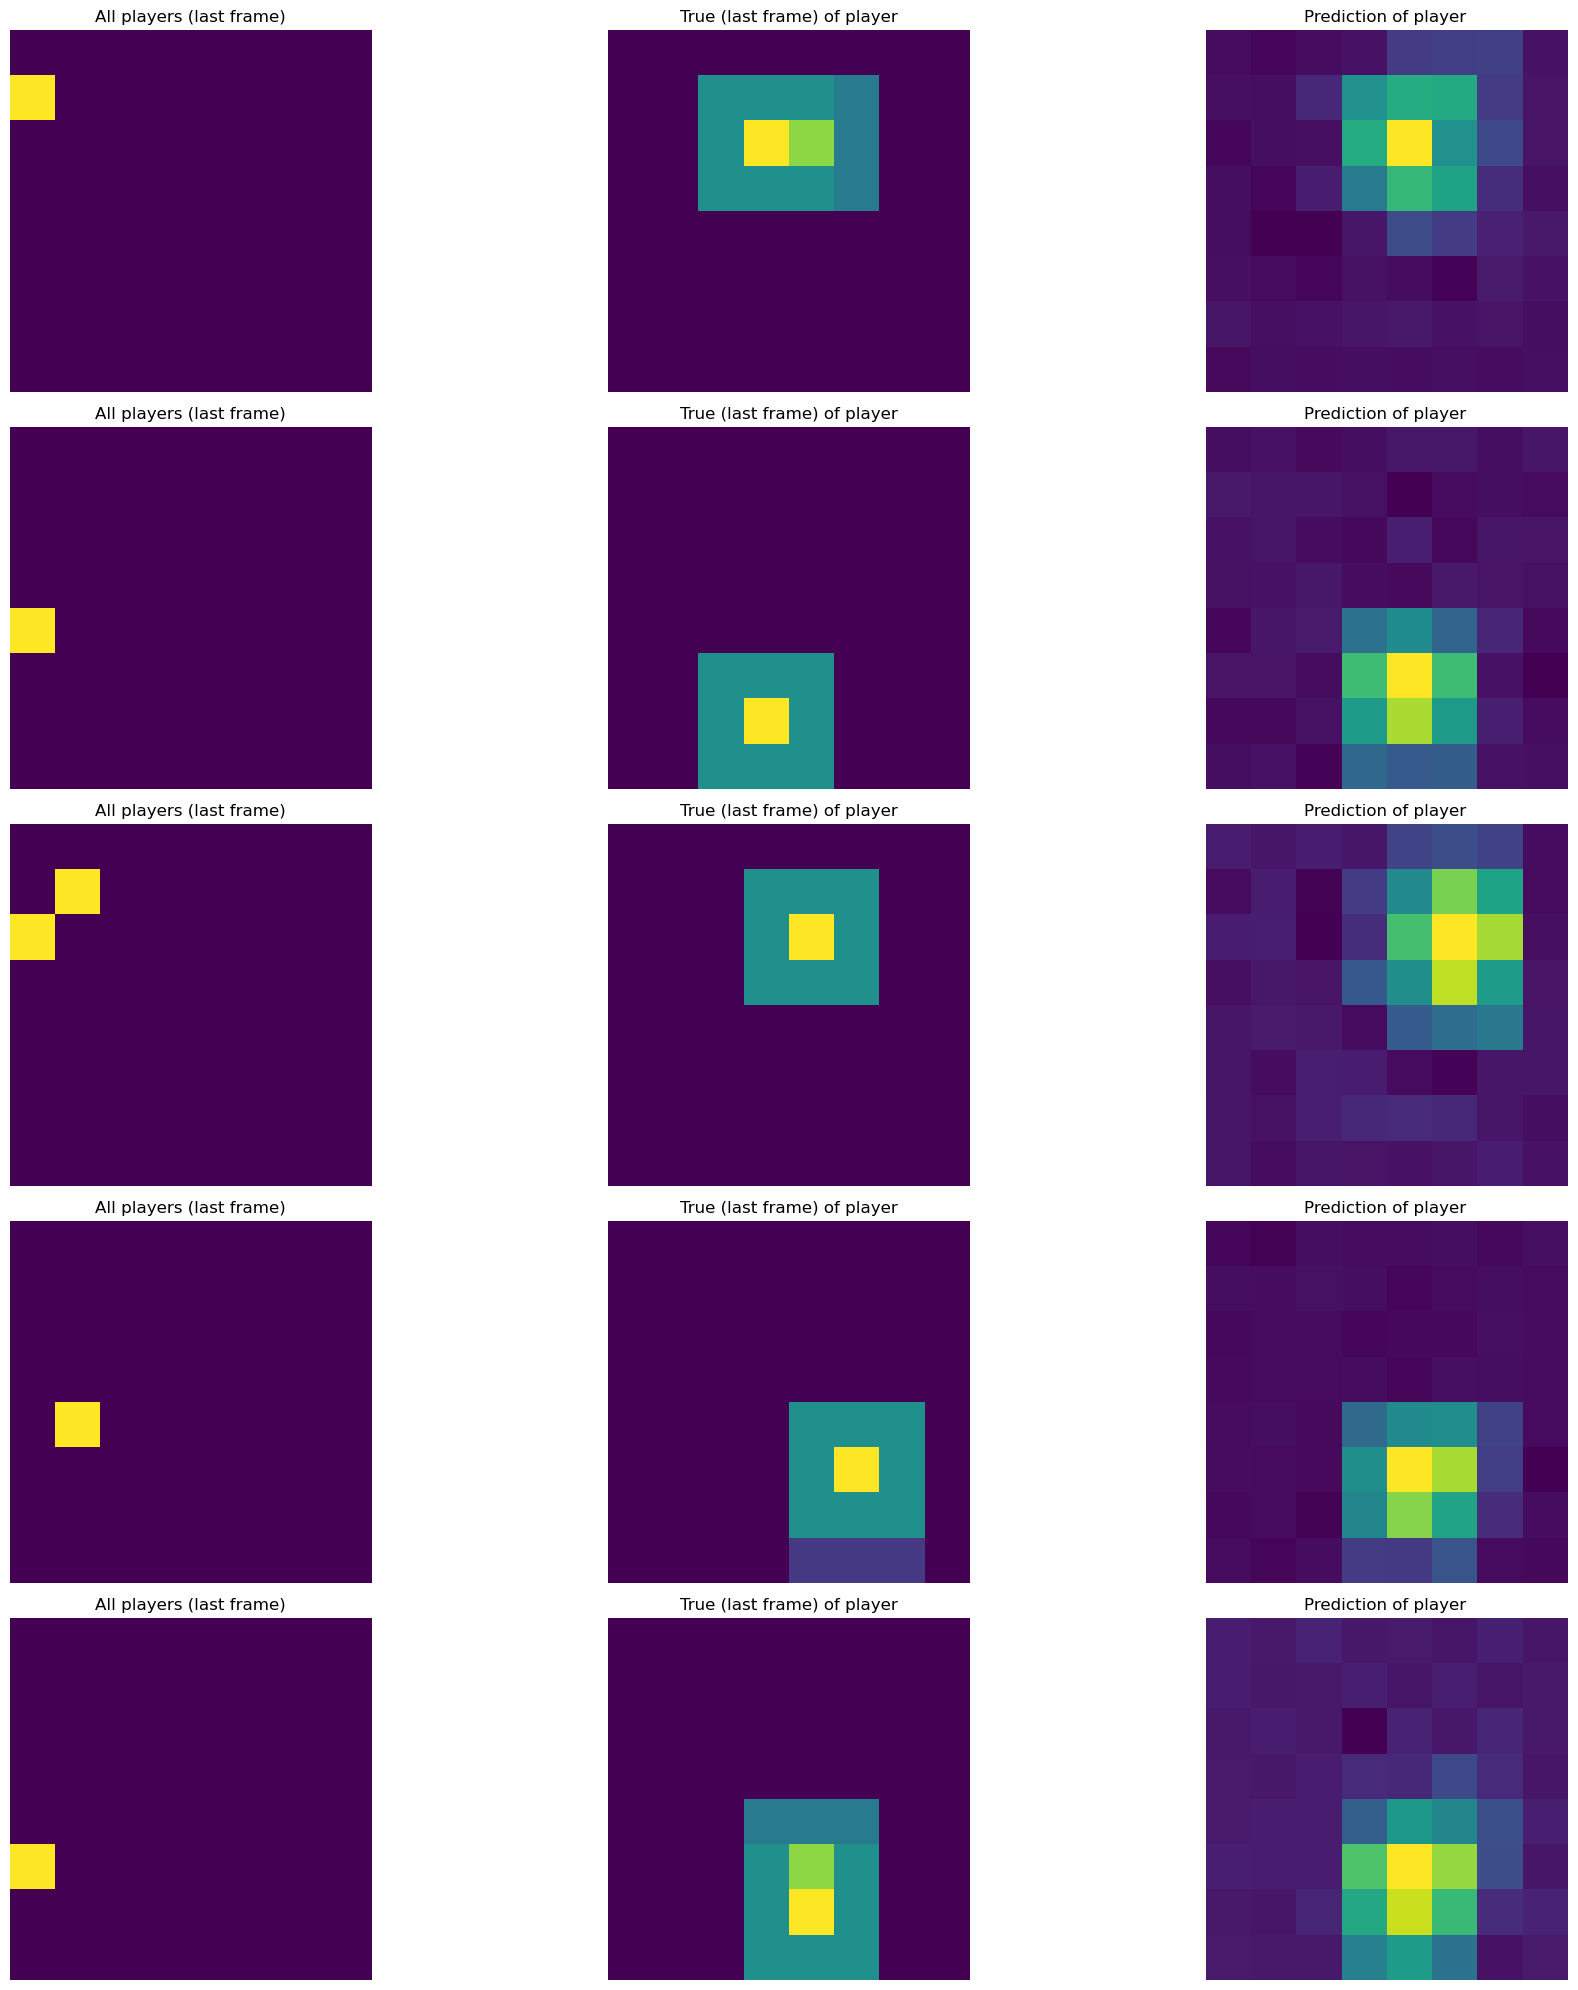

MODELO model0 - ESCENA Scene4
Epoch 1/50
9/9 [==============================] - 7s 219ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.0837 - val_loss: 0.0398 - val_mse: 0.0398 - val_mae: 0.0958
Epoch 2/50
9/9 [==============================] - 1s 134ms/step - loss: 0.0328 - mse: 0.0328 - mae: 0.1022 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1095
Epoch 3/50
9/9 [==============================] - 1s 133ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.0982 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.0944
Epoch 4/50
9/9 [==============================] - 1s 132ms/step - loss: 0.0276 - mse: 0.0276 - mae: 0.0945 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.0956
Epoch 5/50
9/9 [==============================] - 1s 132ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.0915 - val_loss: 0.0279 - val_mse: 0.0279 - val_mae: 0.0934
Epoch 6/50
9/9 [==============================] - 1s 132ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.0926 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.091

2/2 [==============================] - 1s 56ms/step


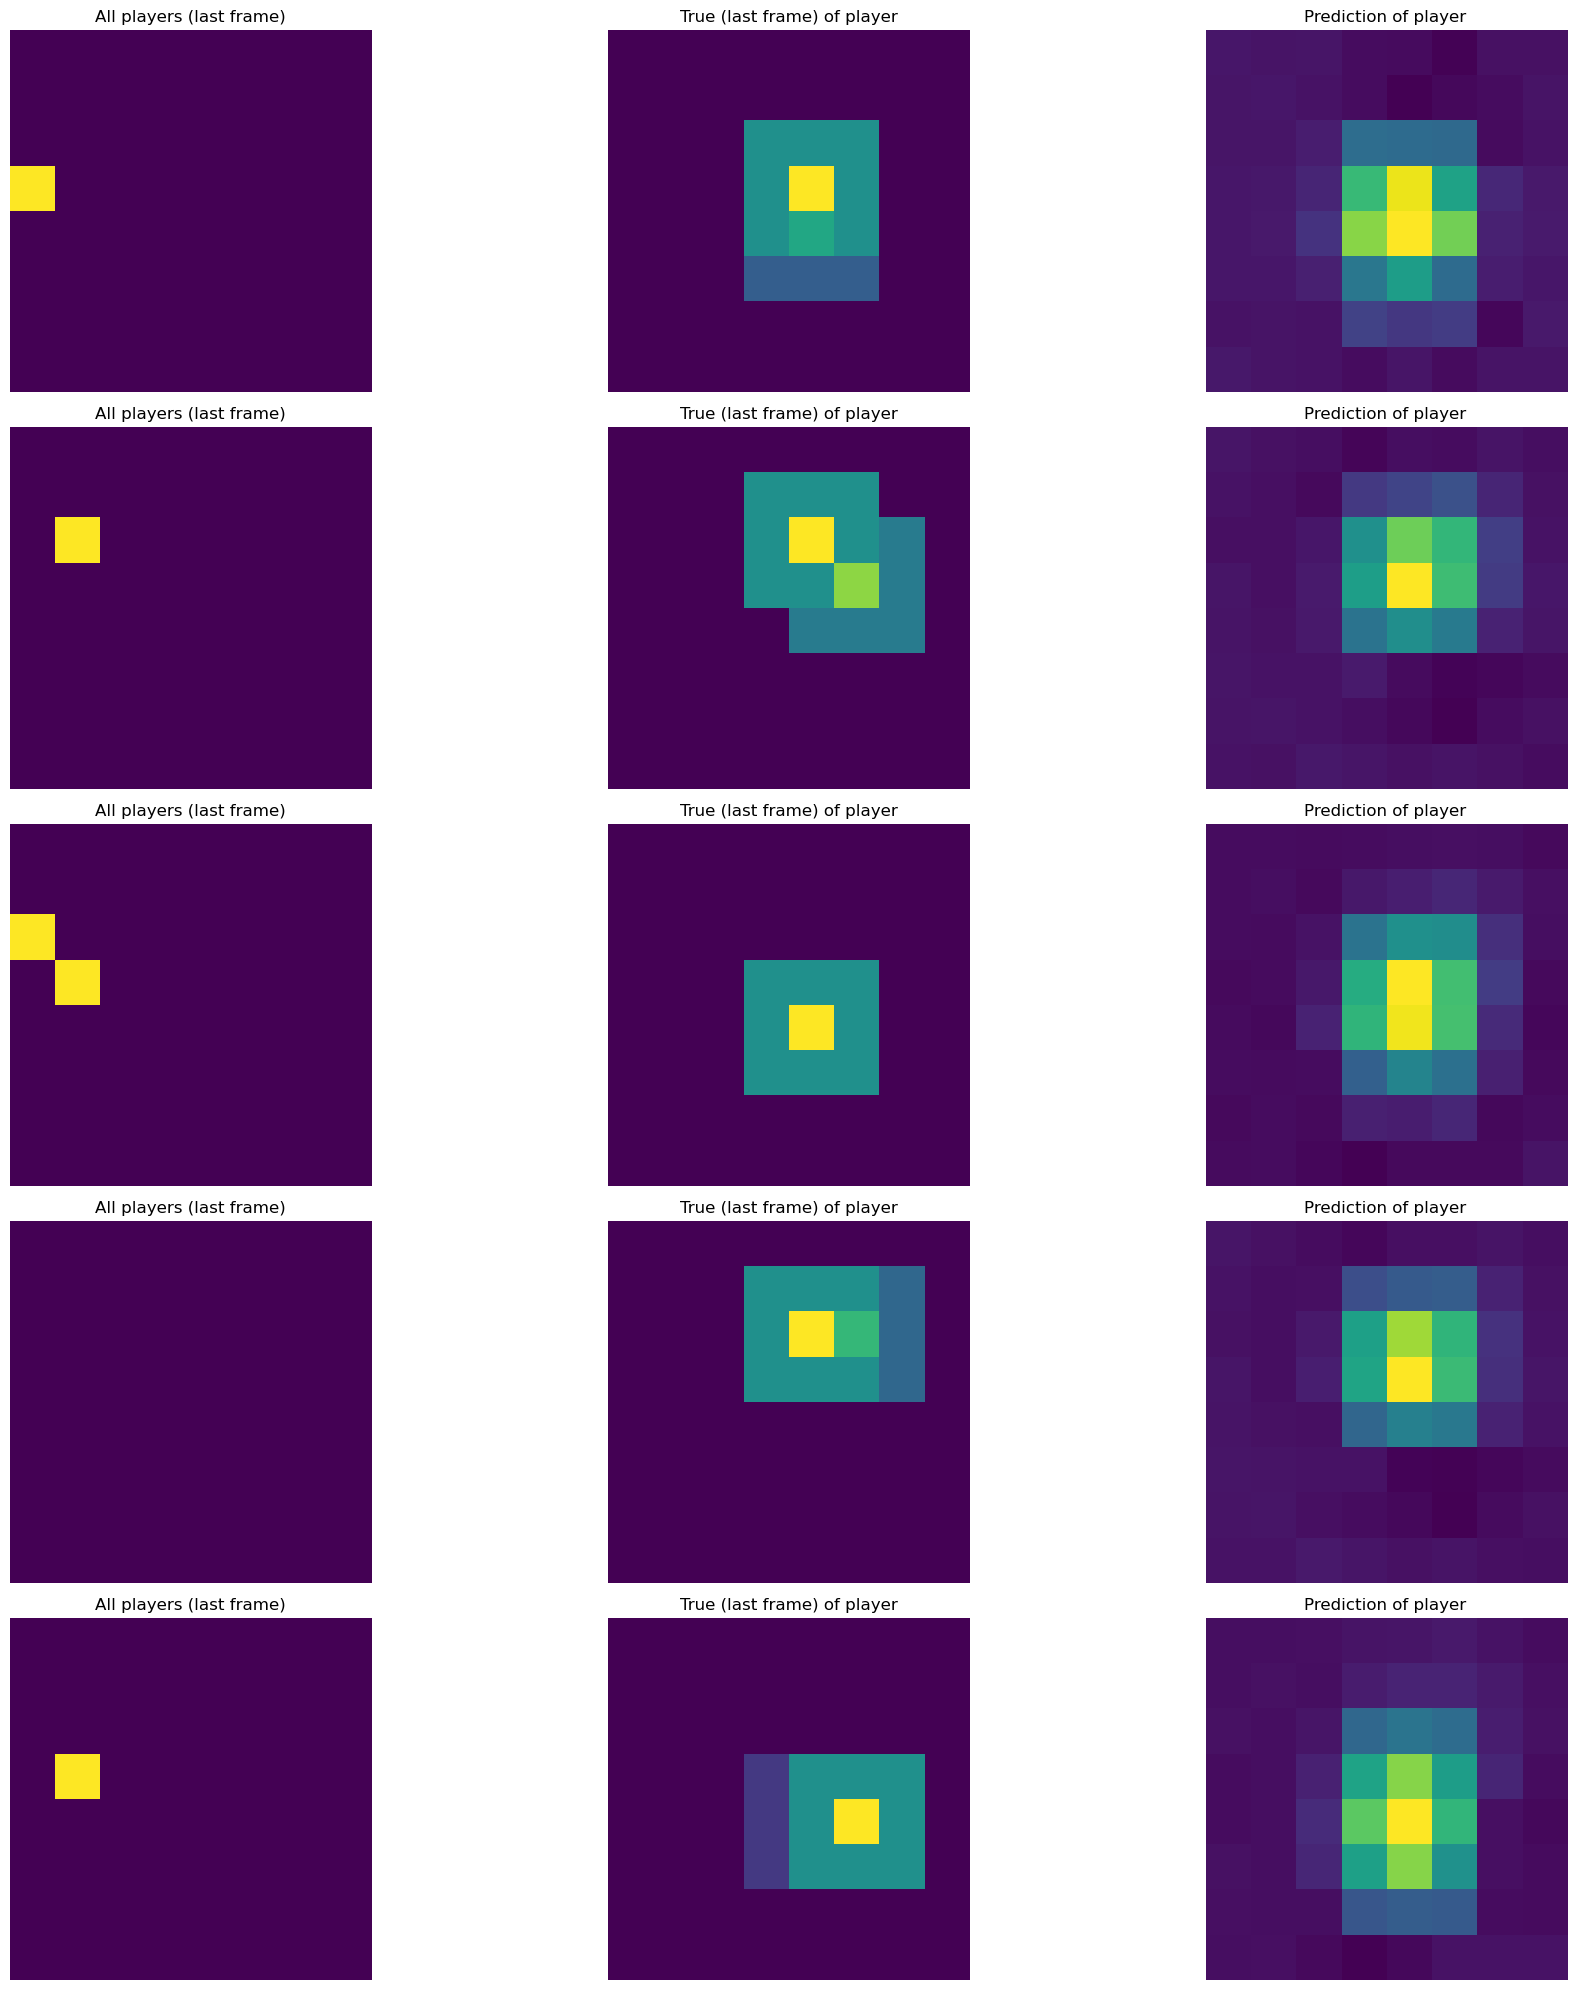

MODELO model1 - ESCENA Scene4
Epoch 1/50
9/9 [==============================] - 3s 171ms/step - loss: 0.0389 - mse: 0.0389 - mae: 0.0857 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1008
Epoch 2/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.0939 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.0816
Epoch 3/50
9/9 [==============================] - 1s 100ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0738 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0683
Epoch 4/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0659 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.0651
Epoch 5/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0620 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0600
Epoch 6/50
9/9 [==============================] - 1s 100ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0583 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0587
E

2/2 [==============================] - 1s 25ms/step


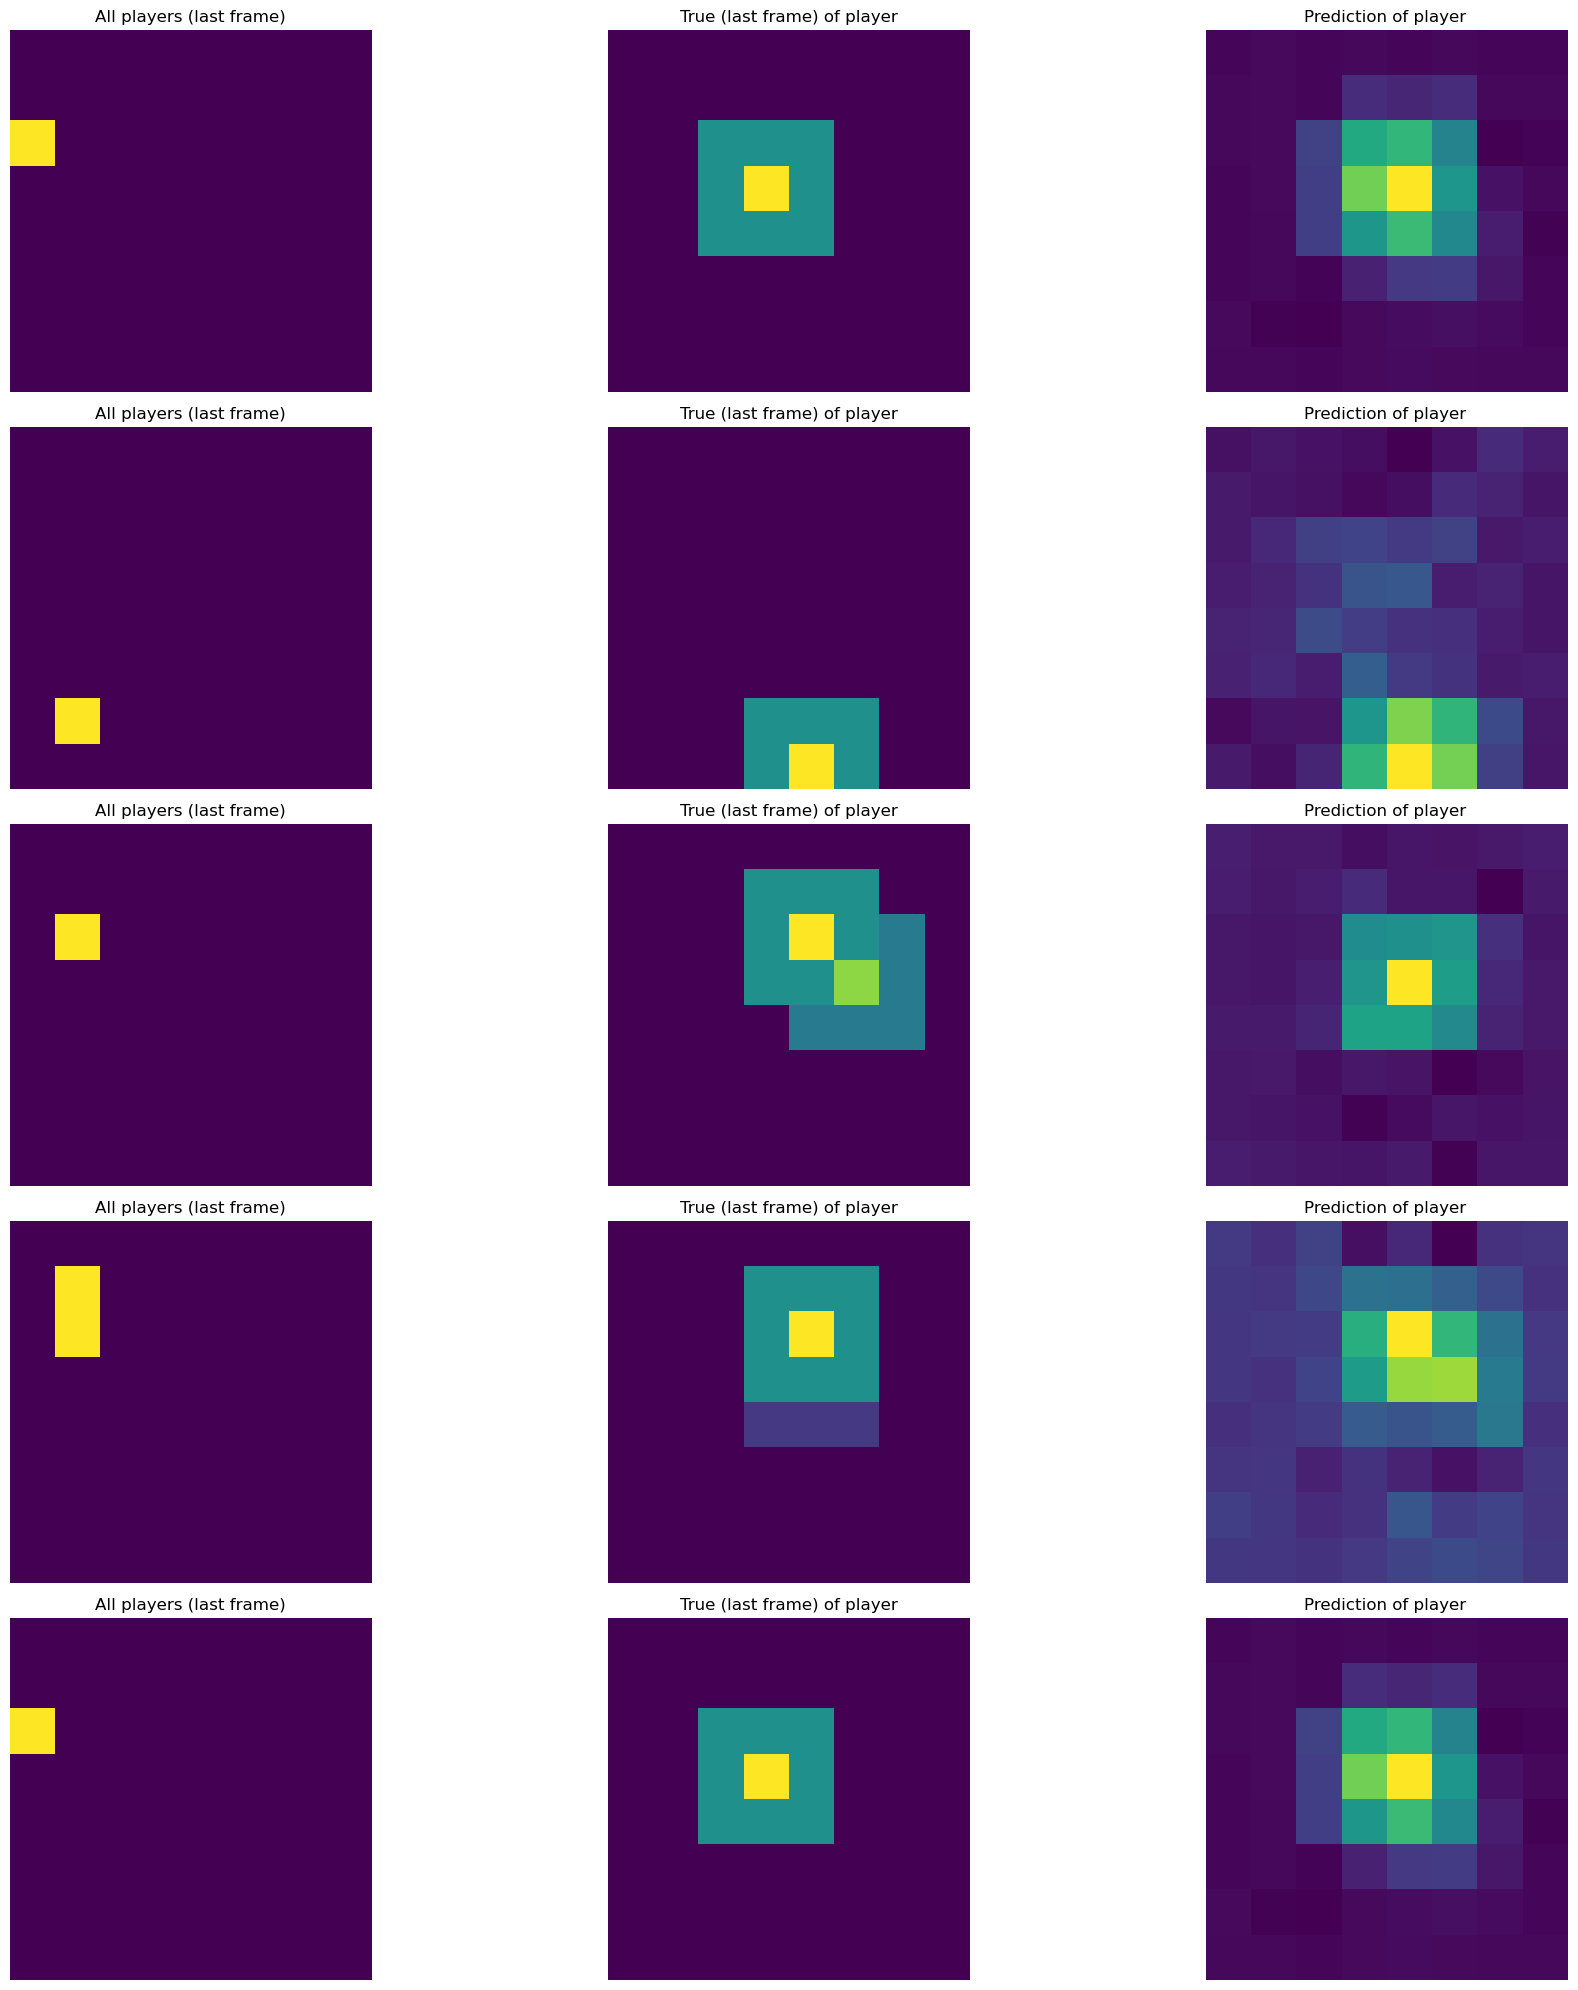

MODELO model2 - ESCENA Scene4
Epoch 1/50
9/9 [==============================] - 4s 244ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.0872 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1063
Epoch 2/50
9/9 [==============================] - 2s 175ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.0981 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.0849
Epoch 3/50
9/9 [==============================] - 2s 174ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.0764 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0716
Epoch 4/50
9/9 [==============================] - 2s 174ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0683 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.0657
Epoch 5/50
9/9 [==============================] - 2s 173ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0620 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0603
Epoch 6/50
9/9 [==============================] - 2s 173ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0600 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.057

2/2 [==============================] - 1s 78ms/step


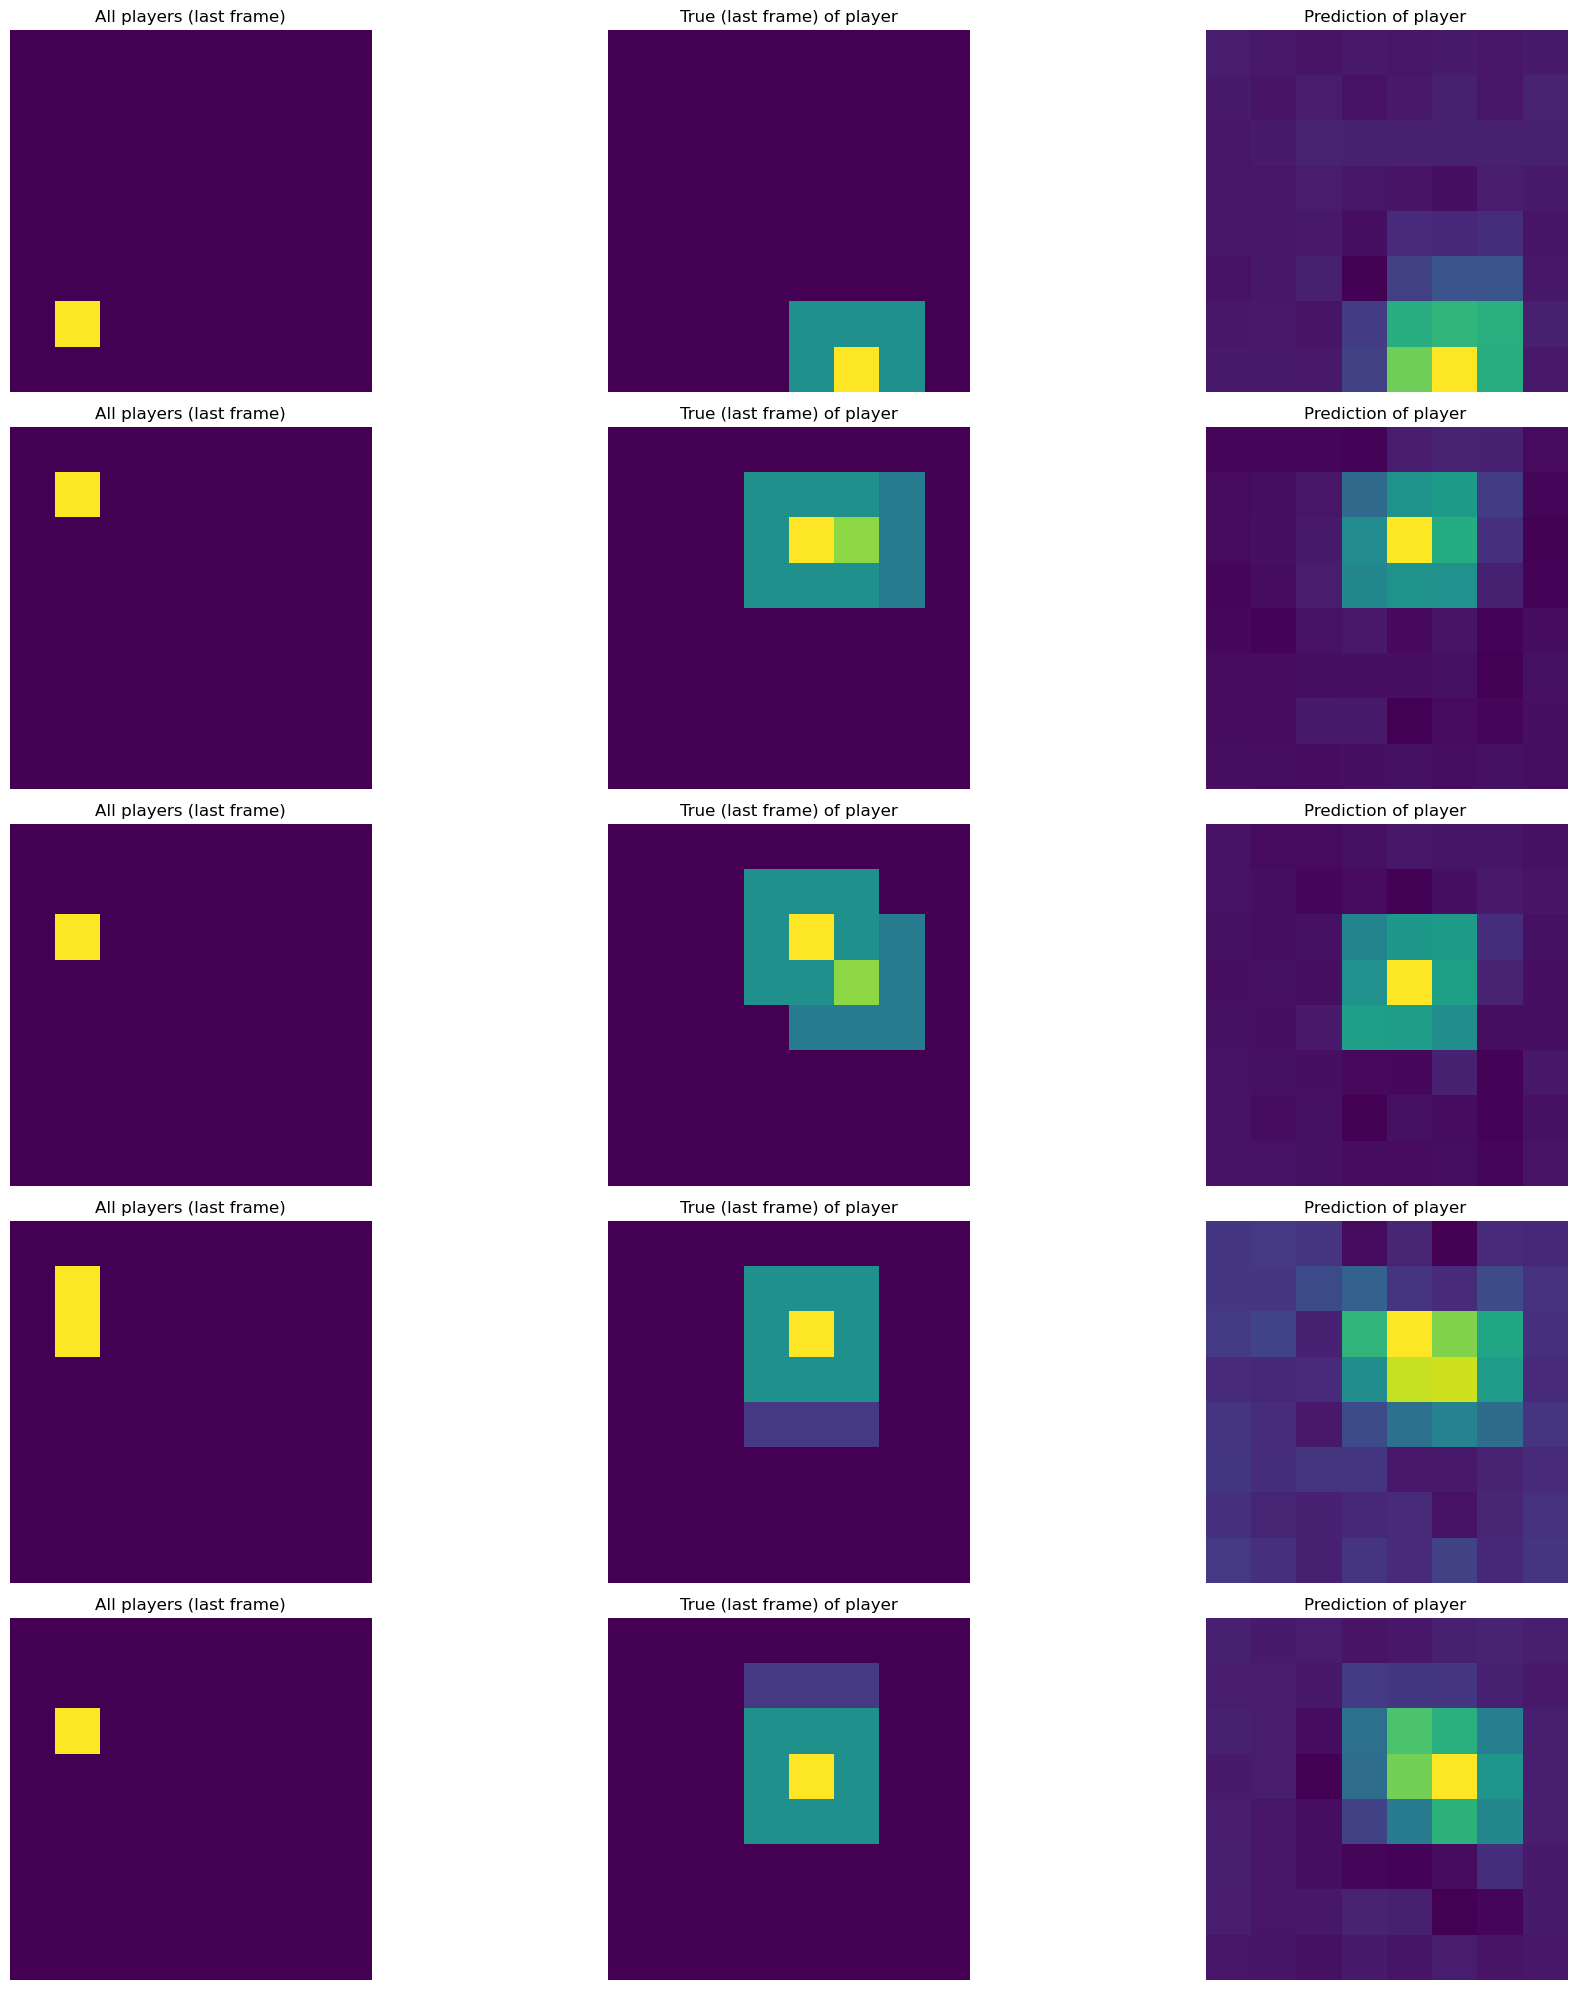

MODELO transf1 - ESCENA Scene4
Epoch 1/50
9/9 [==============================] - 16s 2s/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1310 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1144
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1035 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1038
Epoch 3/50
9/9 [==============================] - 15s 2s/step - loss: 0.0234 - mse: 0.0234 - mae: 0.0916 - val_loss: 0.0255 - val_mse: 0.0255 - val_mae: 0.0920
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0796 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.0809
Epoch 5/50
9/9 [==============================] - 15s 2s/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0714 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.0745
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0631 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0692
Epoch 7/5

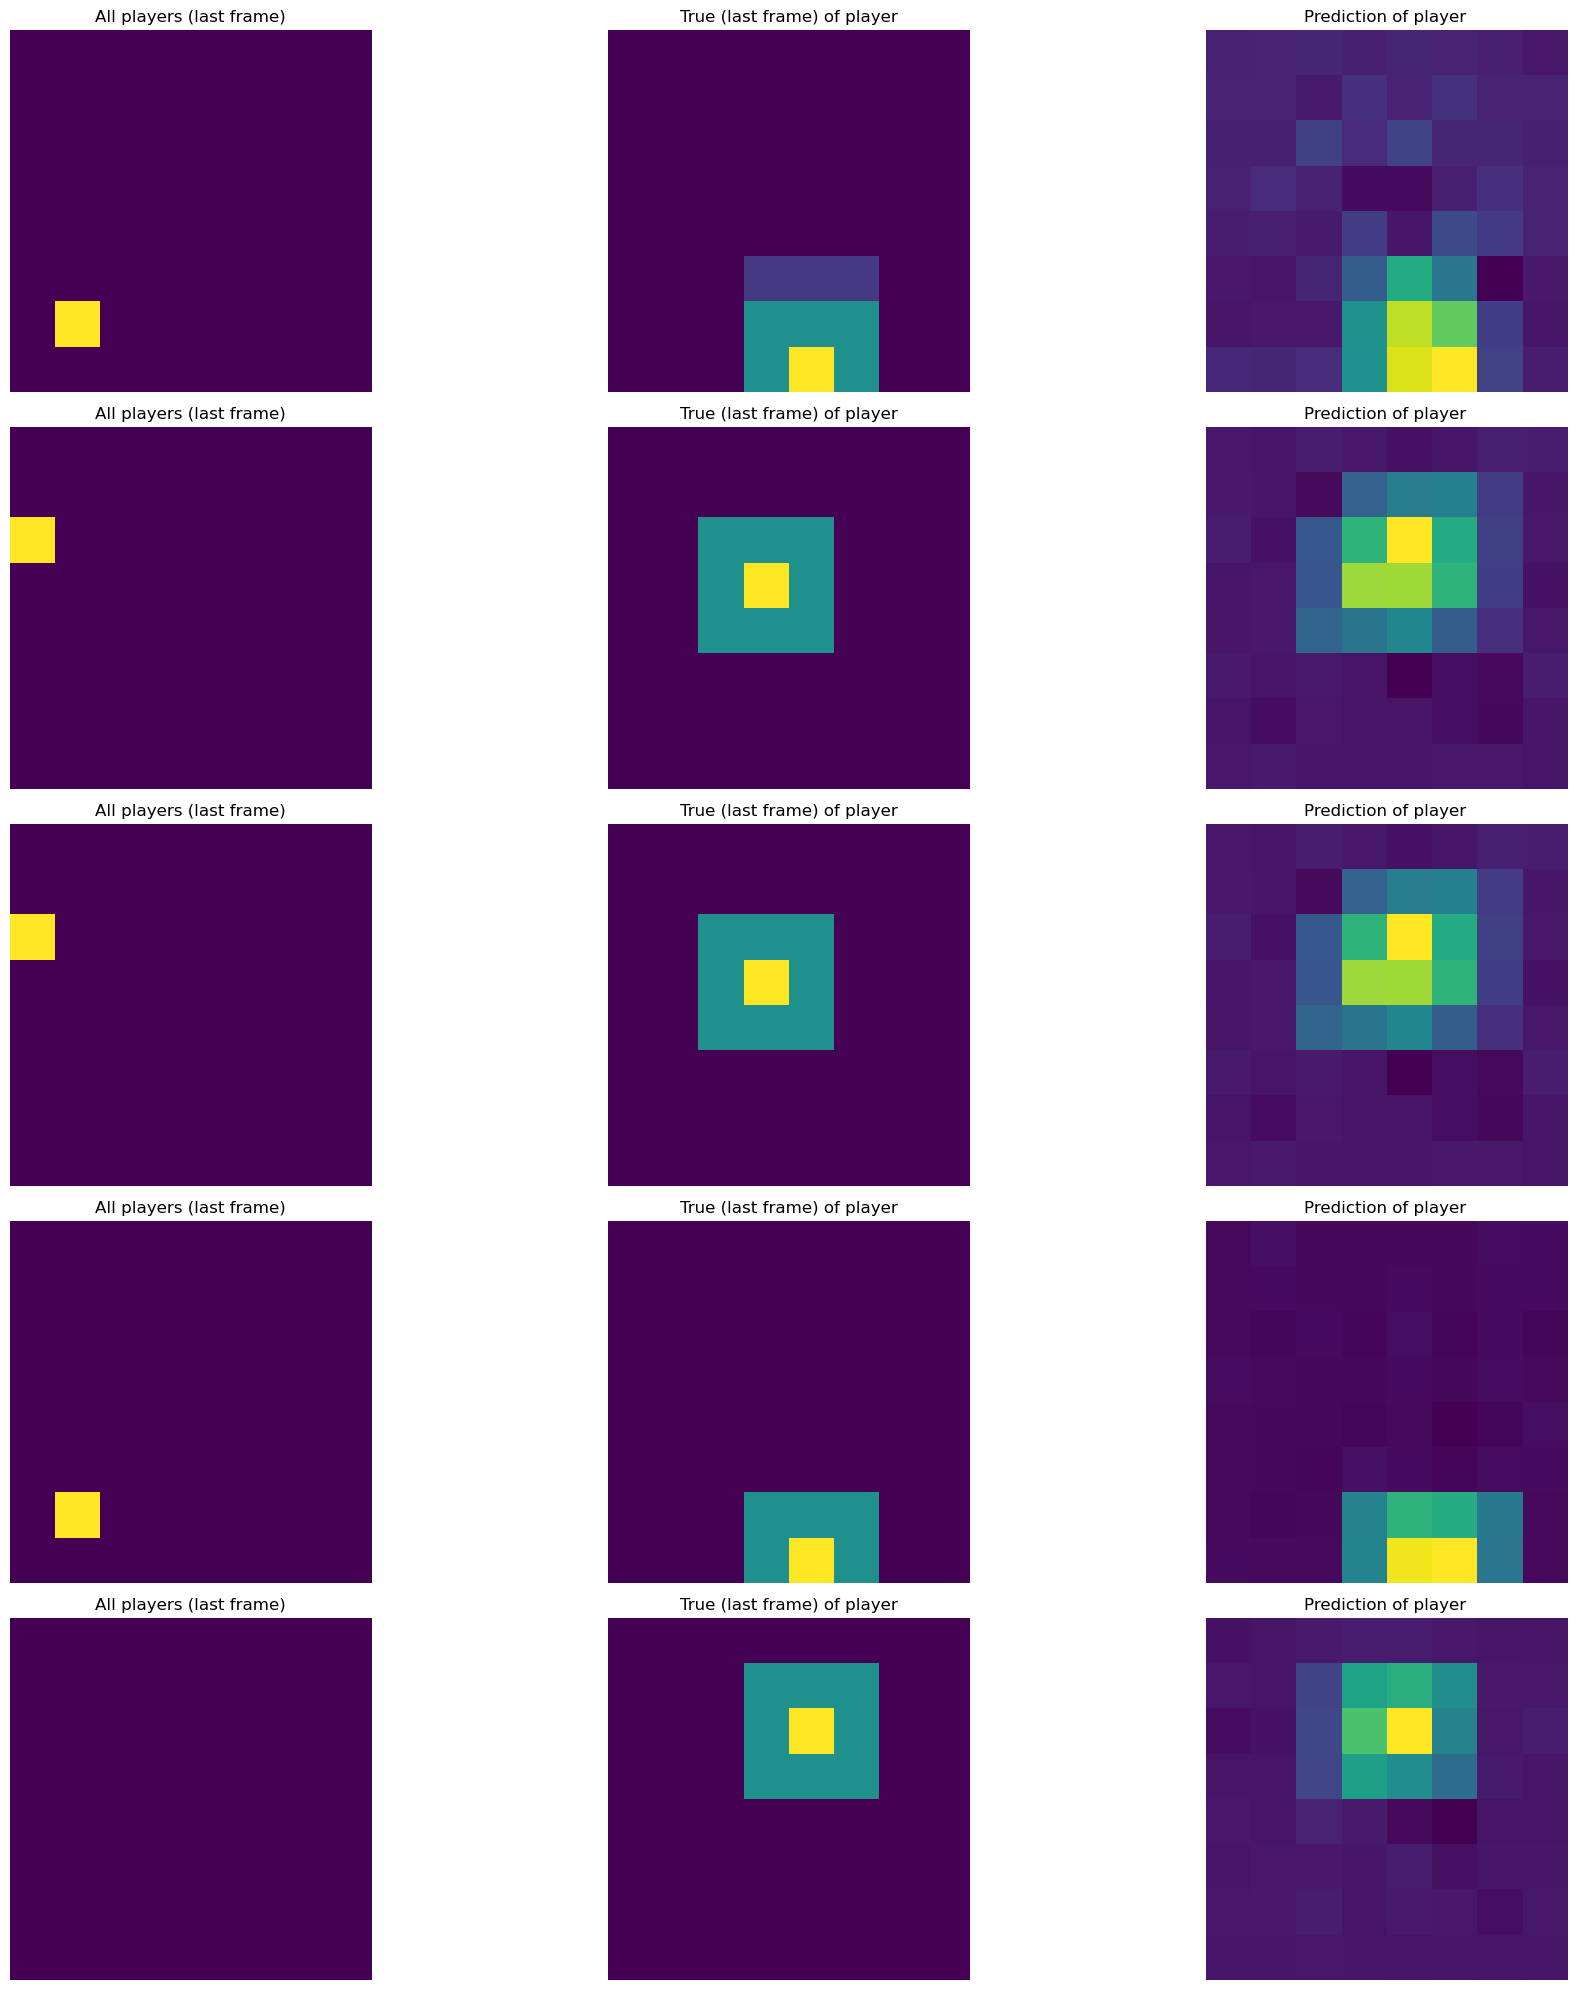

Resultados por escena:
Escena Scene1:
Modelo model0 - MSE: 0.0148, MAE: 0.0544, Tiempo: 19.97s
Modelo model1 - MSE: 0.0163, MAE: 0.0588, Tiempo: 11.78s
Modelo model2 - MSE: 0.0158, MAE: 0.0562, Tiempo: 25.65s
Modelo transf1 - MSE: 0.0165, MAE: 0.0566, Tiempo: 129.45s

Escena Scene2:
Modelo model0 - MSE: 0.0130, MAE: 0.0508, Tiempo: 82.61s
Modelo model1 - MSE: 0.0147, MAE: 0.0574, Tiempo: 46.29s
Modelo model2 - MSE: 0.0141, MAE: 0.0537, Tiempo: 72.41s
Modelo transf1 - MSE: 0.0160, MAE: 0.0582, Tiempo: 544.64s

Escena Scene3:
Modelo model0 - MSE: 0.0133, MAE: 0.0530, Tiempo: 54.09s
Modelo model1 - MSE: 0.0181, MAE: 0.0632, Tiempo: 34.76s
Modelo model2 - MSE: 0.0163, MAE: 0.0599, Tiempo: 57.92s
Modelo transf1 - MSE: 0.0222, MAE: 0.0712, Tiempo: 577.97s

Escena Scene4:
Modelo model0 - MSE: 0.0157, MAE: 0.0574, Tiempo: 64.21s
Modelo model1 - MSE: 0.0185, MAE: 0.0635, Tiempo: 46.84s
Modelo model2 - MSE: 0.0211, MAE: 0.0644, Tiempo: 83.01s
Modelo transf1 - MSE: 0.0200, MAE: 0.0651, Tiempo: 75

In [18]:
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

# Assuming you have a function to calculate binary cross-entropy (log loss)
def binary_cross_entropy(y_true, y_pred):
    """
    Calcula la Binary Cross-Entropy (BCE) asegurando que y_true y y_pred sean válidos.
    Soporta etiquetas no binarias (soft labels).
    """
    # Asegurar que los valores de y_pred estén entre 0 y 1
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Asegurar que los valores de y_true estén en el rango [0,1]
    y_true = np.clip(y_true, 0, 1)

    # Fórmula BCE: -(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
    bce = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(bce)

np.random.seed(42)

# Lista de identificadores de modelo
model_ids = ["model0","model1","model2","transf1"] 


# Estructuras para almacenar resultados y tiempos de ejecución
mse_results = {model_id: [] for model_id in model_ids}
bce_results = {model_id: [] for model_id in model_ids} #binary cross entropy
mae_results = {model_id: [] for model_id in model_ids}
training_times = {model_id: [] for model_id in model_ids}
total_execution_time = {model_id: 0 for model_id in model_ids}

print(np.unique(S))

escenas_seleccionadas=np.unique(S)
#escenas_seleccionadas=escenas_seleccionadas[3:]
print("Para esta ejecución se han seleccionada las escenas: ")
print(escenas_seleccionadas)

for ixs, sc in enumerate(escenas_seleccionadas):
    # Índices para entrenamiento y prueba
    train_indices = np.where(S != sc)[0]
    test_indices = np.where(S == sc)[0]
    np.random.shuffle(train_indices)

    XYT_train = XYT[train_indices]
    rssiT_train = rssiT[train_indices]
    YT_train = YT[train_indices]

    XYT_test = XYT[test_indices]
    rssiT_test = rssiT[test_indices]
    YT_test = YT[test_indices]
    
    for model_id in model_ids:
        print(f"MODELO {model_id} - ESCENA {sc}")
        
        model = load_model(f"{model_id}.h5")

        start_time = time.time()

        history = model.fit([XYT_train, rssiT_train], YT_train,
                                  batch_size=16,
                                  validation_data=([XYT_test, rssiT_test], YT_test),
                                  epochs=50)
        end_time = time.time()
        training_time = end_time - start_time
        
        YT_prediction = model.predict([XYT_test, rssiT_test])

        plottingRandom(XYT_test, YT_test, YT_prediction)

        mse = mean_squared_error(YT_test.flatten(), YT_prediction.flatten())
        mae = mean_absolute_error(YT_test.flatten(), YT_prediction.flatten())
        bce = binary_cross_entropy(YT_test.flatten(), YT_prediction.flatten())

        mse_results[model_id].append(mse)
        mae_results[model_id].append(mae)
        bce_results[model_id].append(bce)
        
       
        training_times[model_id].append(training_time)
        total_execution_time[model_id] += training_time

# Calculando promedios y mostrando resultados

print("Resultados por escena:")
for i, sc in enumerate(escenas_seleccionadas):
    print(f"Escena {sc}:")
    for model_id in model_ids:
        print(f"Modelo {model_id} - MSE: {mse_results[model_id][i]:.4f}, MAE: {mae_results[model_id][i]:.4f}, Tiempo: {training_times[model_id][i]:.2f}s")
    print("")
    
print("RESUMEN RESULTADOS:")
for model_id in model_ids:
    average_mse = np.mean(mse_results[model_id])
    average_mae = np.mean(mae_results[model_id])
    average_bce = np.mean(bce_results[model_id])
    print(f"Modelo {model_id}:")
    print(f"Tiempo de ejecución total: {total_execution_time[model_id]:.2f} segundos")
    print(f"MSE promedio: {average_mse:.4f}")
    print(f"MAE promedio: {average_mae:.4f}\n")
    print(f"BCE promedio: {average_bce:.4f}\n")


In [ ]:
ts.sort()
print(ts)